In [2]:
# check current directory

pwd()


"/Users/xyliu/Desktop/ISE 616 final/ISE-616-final"

In [3]:
using JuMP
using Ipopt   
using LinearAlgebra
using MathOptInterface
const MOI = MathOptInterface
using Random



# Modeling

## function of one-hot encoding

In [4]:
############################
# Encoding information type
############################

"""
    ZGEncodingInfo

Stores the information needed to convert between
original (integer-coded) categorical/group features
and their one-hot encodings.

Fields:
- k_z::Vector{Int}     : number of categories for each categorical component (length m)
- z_start::Vector{Int} : start index (column) of each component in Z_onehot (length m)
- num_g::Int           : total number of groups
"""

struct ZGEncodingInfo
    k_z::Vector{Int}
    z_start::Vector{Int}
    num_g::Int
end



#############################################
# Original (Z, group) → Reduced (Z_enc, G_enc)
#############################################

"""
    encode_zg_reduced(Z::AbstractMatrix{<:Integer},
                      group::AbstractVector{<:Integer})

Encode categorical features Z and group indexes into a reduced dummy
representation:

- Each categorical component l with k_l levels is mapped to (k_l - 1)
  dummy variables. The last category k_l is the baseline (all zeros).
- The group variable with num_g levels is mapped to (num_g - 1)
  dummy variables. The last group num_g is the baseline (all zeros).

Input:
- Z     : N × m matrix, each column l stores an integer in {1, ..., k_l}
- group : length-N vector, each entry in {1, ..., num_g}

Output:
- Z_enc : N × sum_l (k_l - 1) matrix (reduced dummies for Z)
- G_enc : N × (num_g - 1) matrix (reduced dummies for group)
- info  : ZGEncodingInfo, stores the encoding scheme for later decoding
"""
function encode_zg_reduced(Z::AbstractMatrix{<:Integer},
                           group::AbstractVector{<:Integer})
    N, m = size(Z)
    @assert length(group) == N "group must have length N"

    # k_z[l] = number of categories for component l (assumed {1, ..., k_l})
    k_z = [maximum(Z[:, l]) for l in 1:m]

    # Column start indices in the reduced dummy matrix Z_enc.
    # Component l uses (k_z[l] - 1) columns (baseline = category k_z[l]).
    z_start = Vector{Int}(undef, m)
    col = 1
    for l in 1:m
        z_start[l] = col
        d_l = max(k_z[l] - 1, 0)  # number of dummies for component l
        col += d_l
    end
    total_z = col - 1   # total number of columns in Z_enc

    # Allocate Z_enc: N × total_z
    Z_enc = zeros(Int8, N, total_z)

    for i in 1:N
        for l in 1:m
            val = Z[i, l]
            @assert 1 ≤ val ≤ k_z[l] "Category out of range in column $l (row $i)"

            k_l = k_z[l]
            d_l = max(k_l - 1, 0)

            # If d_l == 0, there is effectively a single category (no column needed).
            if d_l > 0 && val < k_l
                col0 = z_start[l]              # start index for component l
                Z_enc[i, col0 + val - 1] = 1   # categories 1..(k_l-1)
            end
            # If val == k_l, baseline category -> all zeros for this component
        end
    end

    # Encode group using (num_g - 1) dummies; last group is baseline.
    num_g = maximum(group)
    d_g   = max(num_g - 1, 0)
    G_enc = zeros(Int8, N, d_g)

    if d_g > 0
        for i in 1:N
            gi = group[i]
            @assert 1 ≤ gi ≤ num_g "Group index out of range at row $i"

            if gi < num_g
                # Non-baseline group in {1, ..., num_g - 1}
                G_enc[i, gi] = 1
            else
                # Baseline group num_g -> all zeros
            end
        end
    end

    info = ZGEncodingInfo(k_z, z_start, num_g)
    return Z_enc, G_enc, info
end


encode_zg_reduced

## test one-hot encode

In [5]:
# testing
Z = [
    1  1;   # row 1
    2  3;   # row 2
    3  2;   # row 3
    1  3;   # row 4
]
# group: length-N vector, values in {1,2,3}
group = [1, 2, 1, 3]

#######################
# 2. Run encoding
#######################

Z_enc, G_onehot, info = encode_zg_reduced(Z, group)
println("Original Z:")
println(Z)
println()

println("Encoded Z_enc (reduced one-hot):")
println(Z_enc)
println("size(Z_enc) = ", size(Z_enc))
println()

println("Group one-hot G_onehot:")
println(G_onehot)
println("size(G_onehot) = ", size(G_onehot))
println()

println("Encoding info:")
println("  k_z     = ", info.k_z)
println("  z_start = ", info.z_start)
println("  num_g   = ", info.num_g)

Original Z:
[1 1; 2 3; 3 2; 1 3]

Encoded Z_enc (reduced one-hot):
Int8[1 0 1 0; 0 1 0 0; 0 0 0 1; 1 0 0 0]
size(Z_enc) = (4, 4)

Group one-hot G_onehot:
Int8[1 0; 0 1; 1 0; 0 0]
size(G_onehot) = (4, 2)

Encoding info:
  k_z     = [3, 3]
  z_start = [1, 3]
  num_g   = 3


In [6]:
#############################################
# Reduced (Z_enc, G_enc) → Original (Z, group)
#############################################

"""
    decode_zg_reduced(Z_enc::AbstractMatrix{<:Integer},
                      G_enc::AbstractMatrix{<:Integer},
                      info::ZGEncodingInfo)

Decode reduced dummy encoded categorical and group features back to
their original integer-coded form.

For each categorical component l with k_l levels:
- If the corresponding block has all zeros, we recover category k_l
  (the baseline).
- Otherwise, the position of the 1 determines the category in {1, ..., k_l - 1}.

For the group variable with num_g levels:
- If the row in G_enc is all zeros, we recover group num_g (baseline).
- Otherwise, the position of the 1 determines the group in {1, ..., num_g - 1}.

Input:
- Z_enc : N × sum_l (k_l - 1) matrix (reduced dummies for Z)
- G_enc : N × (num_g - 1) matrix (reduced dummies for group)
- info  : ZGEncodingInfo produced earlier by `encode_zg_reduced`

Output:
- Z     : N × m matrix, each entry in {1, ..., k_l}
- group : length-N vector, each entry in {1, ..., num_g}
"""
function decode_zg_reduced(Z_enc::AbstractMatrix{<:Integer},
                           G_enc::AbstractMatrix{<:Integer},
                           info::ZGEncodingInfo)
    N, total_z = size(Z_enc)
    m = length(info.k_z)

    # Check group encoding consistency
    num_g = info.num_g
    d_g   = max(num_g - 1, 0)
    @assert size(G_enc, 1) == N "Z_enc and G_enc must have same number of rows"
    @assert size(G_enc, 2) == d_g "G_enc columns must be num_g - 1"

    # Recover categorical matrix Z (N × m)
    Z = zeros(Int, N, m)
    for l in 1:m
        k_l = info.k_z[l]
        d_l = max(k_l - 1, 0)
        s   = info.z_start[l]
        e   = s + d_l - 1

        if d_l == 0
            # Only one category exists for this component; always category 1.
            for i in 1:N
                Z[i, l] = 1
            end
            continue
        end

        @assert e ≤ total_z "Z_enc has too few columns for component $l"

        # View the reduced dummy block for component l
        sub = @view Z_enc[:, s:e]  # N × d_l
        for i in 1:N
            idx = findfirst(==(1), sub[i, :])
            if idx === nothing
                # All zeros: baseline category k_l
                Z[i, l] = k_l
            else
                # Non-baseline category in {1, ..., k_l - 1}
                Z[i, l] = idx
            end
        end
    end

    # Recover group vector (length N) from reduced dummies
    group = Vector{Int}(undef, N)
    if d_g == 0
        # Only one group; always group 1
        for i in 1:N
            group[i] = 1
        end
    else
        for i in 1:N
            idx = findfirst(==(1), G_enc[i, :])
            if idx === nothing
                # Baseline group num_g
                group[i] = num_g
            else
                # Non-baseline group in {1, ..., num_g - 1}
                group[i] = idx
            end
        end
    end

    return Z, group
end


decode_zg_reduced

## test one-hot decode

In [7]:
Z, group = decode_zg_reduced(Z_enc, G_onehot, info)
Z, group

([1 1; 2 3; 3 2; 1 3], [1, 2, 1, 3])

## DAG builder

In [7]:
###############################
# Graph structure for sample-level DAGs
# compatible with Theorem 2 (graph-based formulation)
###############################

# -----------------------------
# Arc kind (structure only)
# -----------------------------

"""
    ArcKind

Abstract type for different kinds of arcs in the DAG.
We distinguish between:
  - `CatArc` : categorical feature transitions
  - `TermArc`: terminal transitions to (m+1, 0) with a chosen group g
"""
abstract type ArcKind end

"""
    CatArc

Categorical arc corresponding to choosing category `c` for component `k`.

Fields:
- k      : which categorical component (1..m)
- c      : chosen category in {1, ..., k_z[k]}
- d_prev : previous accumulated categorical distance at state (k-1, d_prev)
- d      : new accumulated distance at state (k, d)
"""

struct CatArc <: ArcKind
    k::Int
    c::Int
    d_prev::Float64
    d::Float64
end

"""
    TermArc

Terminal arc from (m, d) to (m+1, 0) with a chosen destination group g.

Fields:
- d : accumulated categorical distance at state (m, d)
- g : destination group in {1, ..., num_g}
"""
struct TermArc <: ArcKind
    d::Float64
    g::Int
end

# -----------------------------
# Arc and per-sample DAG
# -----------------------------

"""
    Arc

Directed edge in the DAG for a single sample i.

Fields:
- src  : index of the source node in `nodes`
- dst  : index of the destination node in `nodes`
- kind : arc type (CatArc or TermArc), which encodes all information
         needed to build w^i(e; β, λ, r_i, ...) later
"""
struct Arc
    src::Int
    dst::Int
    kind::ArcKind
end






"""
    SampleDAG

Graph structure associated with a single sample i, compatible with
Theorem 2 (graph-based formulation).

Fields:
- sample_index : index i of the sample this DAG corresponds to
- nodes        : vector of DP states (k, d), plus the terminal node (m+1, 0.0)
                 each node is a Tuple{Int,Float64}
- arcs         : list of directed edges with their arc kind (no numeric weight)
- source       : index of the source node (corresponds to state (0, 0.0))
- sink         : index of the terminal node (corresponds to state (m+1, 0.0))
"""
struct SampleDAG
    sample_index::Int
    nodes::Vector{Tuple{Int,Float64}}
    arcs::Vector{Arc}
    source::Int
    sink::Int
end




# -----------------------------
# Categorical encoding info
# -----------------------------
"""
    CatEncodingInfo

Encoding information for categorical features (structure level only).

Fields:
- k_z::Vector{Int} : number of categories per component (length m).
                     For component k, categories are {1, ..., k_z[k]}.
- num_g::Int       : total number of groups (used for terminal arcs).
"""
struct CatEncodingInfo
    k_z::Vector{Int}
    num_g::Int
end


# -----------------------------
# Build DAG structure for one sample i
# -----------------------------
"""
    build_sample_dag_structure(i, info, delta, z_i) -> SampleDAG

Build the DAG structure G^i = (V^i, A^i) for a fixed sample i,
compatible with Theorem 2 (graph-based formulation), using our setup.

This function ONLY builds:
  - the nodes (states (k, d) plus the terminal (m+1, 0)),
  - the arcs with their structural information (CatArc or TermArc).

It does NOT compute numeric weights w^i(e). Those should be constructed
later as expressions of (β, λ, r_i, y_i, g_i, B_{g_i}, C_{g_i}, ...).

Arguments:
- i      : sample index
- info   : CatEncodingInfo (k_z, num_g)
- delta  : length-m vector of δ_k in
           d(z, zᶦ) = Σ_k δ_k * 1[z_k ≠ z_kᶦ]
- z_i    : length-m vector of original categories for sample i,
           each z_i[k] ∈ {1, ..., k_z[k]}

Output:
- SampleDAG describing the structure of G^i
"""
function build_sample_dag_structure(
    i::Int,
    info::CatEncodingInfo,
    delta::AbstractVector{<:Real},
    z_i::AbstractVector{<:Integer}
)::SampleDAG
    k_z   = info.k_z
    num_g = info.num_g
    m     = length(k_z)

    # -------------------------
    # 0. Sanity checks
    # -------------------------
    @assert length(delta) == m "delta must have length m"
    @assert length(z_i) == m "z_i must have length m"

    # -------------------------
    # 1. Enumerate states (k, d) with per-layer dedup
    # -------------------------
    nodes = Vector{Tuple{Int,Float64}}()
    node_index = Dict{Tuple{Int,Float64},Int}()

    # Source state (0, 0.0)
    push!(nodes, (0, 0.0))
    node_index[(0, 0.0)] = 1
    source_idx = 1

    arcs = Vector{Arc}()

    # current_layer holds all unique states (k-1, d_prev)
    current_layer = [(0, 0.0)]

    for k in 1:m
        next_layer = Tuple{Int,Float64}[]
        seen_next = Set{Tuple{Int,Float64}}()

        k_l   = k_z[k]
        δ_k   = float(delta[k])
        z_i_k = z_i[k]

        for (k_prev, d_prev) in current_layer
            @assert k_prev == k - 1

            # Enumerate all categories c ∈ {1, ..., k_l}
            for c in 1:k_l
                mismatch = (c != z_i_k)
                d = d_prev + (mismatch ? δ_k : 0.0)
                state = (k, d)

                # Add state to global node list if new
                if !haskey(node_index, state)
                    push!(nodes, state)
                    node_index[state] = length(nodes)
                end

                # Ensure each (k, d) appears at most once in next_layer
                if !(state in seen_next)
                    push!(next_layer, state)
                    push!(seen_next, state)
                end

                # Add categorical arc from (k-1, d_prev) to (k, d)
                src = node_index[(k-1, d_prev)]
                dst = node_index[state]
                kind = CatArc(k, c, d_prev, d)
                push!(arcs, Arc(src, dst, kind))
            end
        end

        # Move to next layer (already deduplicated)
        current_layer = next_layer
    end

    # States with k = m are the final DP layer S_1^i
    # current_layer is already deduplicated, but we keep the name for clarity
    S1_states = current_layer

    # -------------------------
    # 2. Add terminal node (m+1, 0.0) and terminal arcs
    # -------------------------
    terminal_state = (m+1, 0.0)
    push!(nodes, terminal_state)
    node_index[terminal_state] = length(nodes)
    sink_idx = node_index[terminal_state]

    # For each (m, d) in S_1^i, and for each group g, add a TermArc
    for (k_state, d) in S1_states
        @assert k_state == m
        src = node_index[(m, d)]
        for g in 1:num_g
            kind = TermArc(d, g)
            push!(arcs, Arc(src, sink_idx, kind))
        end
    end

    # -------------------------
    # 3. Return SampleDAG
    # -------------------------
    return SampleDAG(i, nodes, arcs, source_idx, sink_idx)
end

build_sample_dag_structure

## test DAG builder

In [17]:
i = 2001

k_z   = [2, 2]      # each component 2 cats
delta = [1.0, 1.0]  # δ₁ = δ₂ = 1
z_i   = [1, 2]      # sample i：z₁ = 1, z₂ = 2
num_g = 2

info = CatEncodingInfo(k_z, num_g)

dag_i = build_sample_dag_structure(i, info, delta, z_i)
dag_i

SampleDAG(2001, [(0, 0.0), (1, 0.0), (1, 1.0), (2, 1.0), (2, 0.0), (2, 2.0), (3, 0.0)], Arc[Arc(1, 2, CatArc(1, 1, 0.0, 0.0)), Arc(1, 3, CatArc(1, 2, 0.0, 1.0)), Arc(2, 4, CatArc(2, 1, 0.0, 1.0)), Arc(2, 5, CatArc(2, 2, 0.0, 0.0)), Arc(3, 6, CatArc(2, 1, 1.0, 2.0)), Arc(3, 4, CatArc(2, 2, 1.0, 1.0)), Arc(4, 7, TermArc(1.0, 1)), Arc(4, 7, TermArc(1.0, 2)), Arc(5, 7, TermArc(0.0, 1)), Arc(5, 7, TermArc(0.0, 2)), Arc(6, 7, TermArc(2.0, 1)), Arc(6, 7, TermArc(2.0, 2))], 1, 7)

## modeling

In [8]:
using JuMP

"""
    build_group_dro_graph_model(
        X, Z, group, y,
        encinfo,
        delta,
        A_group,
        B_group, C_group,
        gamma_x,
        ε,
        optimizer
    ) -> (model, meta)

Build our group-dependent, graph-based DRO logistic regression model,
using the same reduced encoding convention as `ZGEncodingInfo` /
`encode_zg_reduced`.

Arguments
---------
- X        :: N × n_x matrix of continuous features.
- Z        :: N × m   matrix of original categorical features.
              Entry Z[i, k] ∈ {1, ..., k_z[k]} (no one-hot).

- group    :: length-N vector of group indices g_i ∈ {1,...,num_g}.
- y        :: length-N vector of labels in {-1, +1}.

- encinfo  :: ZGEncodingInfo
              (k_z, z_start, num_g) describing reduced encoding blocks
              for the categorical features and groups.

- delta    :: length-m vector δ_k used in
              d_cat(z, z^i) = Σ_k δ_k * 1[z_k ≠ z_k^i].

- A_group  :: length-num_g vector A_g
              continuous-part metric weights in
              A_g Σ_j γ_j |x_j - x_j^i|.

- B_group  :: length-num_g vector B_g
              categorical-part metric weight.

- C_group  :: length-num_g vector C_g
              group-change penalty.

- gamma_x  :: length n_x vector γ_j for continuous features.
              Continuous dual constraint will be
                  |β_{xj}| ≤ λ * A_min * γ_j,
              where A_min = minimum(A_group).

- ε        :: Wasserstein radius ε.

- optimizer: optimizer constructor for JuMP, e.g.
              optimizer_with_attributes(Mosek.Optimizer, "QUIET" => true)

Returns
-------
- model :: JuMP.Model
- meta  :: NamedTuple: (encinfo=encinfo, dags=dags, n_nodes=n_nodes)
"""
function build_group_dro_graph_model(
    X::AbstractMatrix{<:Real},
    Z::AbstractMatrix{<:Integer},
    group::AbstractVector{<:Integer},
    y::AbstractVector{<:Integer},
    encinfo::ZGEncodingInfo,
    delta::AbstractVector{<:Real},
    A_group::AbstractVector{<:Real},
    B_group::AbstractVector{<:Real},
    C_group::AbstractVector{<:Real},
    gamma_x::AbstractVector{<:Real},
    ε::Real,
    optimizer,
)
    # -------------------------
    # 0. Dimensions & sanity checks
    # -------------------------
    N, n_x = size(X)
    N_Z, m = size(Z)
    @assert N_Z == N "X and Z must have the same number of rows (samples)."
    @assert length(group) == N "group must have length N."
    @assert length(y) == N "y must have length N."
    @assert length(delta) == m "delta must have length m."
    @assert length(gamma_x) == n_x "gamma_x must have length n_x."

    k_z     = encinfo.k_z
    z_start = encinfo.z_start
    num_g   = encinfo.num_g

    @assert length(k_z) == m "encinfo.k_z must have length m."
    @assert length(z_start) == m "encinfo.z_start must have length m."
    @assert length(A_group) == num_g "A_group length must equal num_g."
    @assert length(B_group) == num_g "B_group length must equal num_g."
    @assert length(C_group) == num_g "C_group length must equal num_g."

    # Total length of β_z under reduced encoding:
    # last block starts at z_start[m], length (k_z[m] - 1)
    # so p_z = z_start[m] + (k_z[m] - 1) - 1
    p_z = z_start[end] + (k_z[end] - 1) - 1

    # Small positive constant for log(exp(inner) - 1) domain
    # We will enforce: r[i] + λ * inner_coeff ≥ η
    η = 1e-8

    # -------------------------
    # 1. Build per-sample DAGs (discrete part only)
    # -------------------------
    info = CatEncodingInfo(k_z, num_g)

    dags      = Vector{SampleDAG}(undef, N)
    n_nodes   = Vector{Int}(undef, N)
    max_nodes = 0

    for i in 1:N
        # Z[i, :] is an AbstractVector{<:Integer}
        dags[i] = build_sample_dag_structure(i, info, delta, Z[i, :])
        n_nodes[i] = length(dags[i].nodes)
        max_nodes = max(max_nodes, n_nodes[i])
    end

    # -------------------------
    # 2. Create JuMP model & decision variables
    # -------------------------
    model = Model(optimizer)

    # Wasserstein dual variable λ ≥ 0
    @variable(model, λ >= 0.0)

    # Per-sample slack variables r_i ∈ ℝ (free),
    # domain of log(exp(...)-1) will be enforced via extra constraints
    @variable(model, r[1:N])

    # Logistic regression parameters
    @variable(model, β0)                # intercept
    @variable(model, β_x[1:n_x])        # continuous coefficients
    @variable(model, β_z[1:p_z])        # categorical coefficients (reduced)
    @variable(model, β_grp[1:(num_g-1)])# group coefficients (reduced)

    # Graph dual variables μ_i_v for each sample i and each node v
    @variable(model, μ[1:N, 1:max_nodes])

    # -------------------------
    # 3. Objective: λ ε + (1/N) Σ r_i
    # -------------------------
    @objective(model, Min, λ * ε + (1.0 / N) * sum(r[i] for i in 1:N))

    # -------------------------
    # 4. Continuous part dual constraints with A_group
    #
    # Metric for x uses A_g:
    #   d_x(x^i, x; g) = A_g Σ_j γ_j |x_j - x_j^i|
    # Dual boundedness ⇒ for each j:
    #   |β_{xj}| ≤ λ * γ_j * min_g A_g
    # We enforce:
    #   -λ * A_min * γ_j ≤ β_x[j] ≤ λ * A_min * γ_j
    # -------------------------
    A_min = minimum(A_group)

    for j in 1:n_x
        @constraint(model,  β_x[j] <=  λ * A_min * gamma_x[j])
        @constraint(model, -β_x[j] <=  λ * A_min * gamma_x[j])
    end

    # -------------------------
    # 5. Outer logistic inequality:
    #    y^i (β_x^T x^i + β0) ≥ -μ_i(0,0) + μ_i(m+1,0)
    # -------------------------
    for i in 1:N
        dag = dags[i]
        s = dag.source
        t = dag.sink

        # Left-hand side: y_i * (β0 + β_x^T x^i)
        lhs = y[i] * (β0 + sum(β_x[j] * X[i, j] for j in 1:n_x))

        # Right-hand side: - μ_i(source) + μ_i(sink)
        rhs = - μ[i, s] + μ[i, t]

        @constraint(model, lhs >= rhs)
    end

    # -------------------------
    # 6. Edge constraints: μ_t(e) - μ_s(e) ≥ w^i(e)
    #
    # - For CatArc(k,c,...):
    #     w^i(e) = - y^i β_{z_k}^T z_k(c)
    #   Reduced encoding aligned with ZGEncodingInfo:
    #     if c < k_z[k], β_{z_k}^T z_k(c) = β_z[z_start[k] + c - 1]
    #     if c = k_z[k], baseline ⇒ 0.
    #
    # - For TermArc(d,g):
    #     w^i(e) =
    #       - y^i β_grp^T φ_g(g)
    #       - log( exp( r_i + λ (B_{g_i} d + C_{g_i} 1[g ≠ g_i]) ) - 1 )
    #
    #   with group reduced encoding:
    #     if g < num_g: β_grp^T φ_g(g) = β_grp[g]
    #     if g = num_g: baseline ⇒ 0.
    #
    #   Additionally, domain constraints:
    #     r_i + λ (B_{g_i} d + C_{g_i} 1[g ≠ g_i]) ≥ η
    #   ensure that log(exp(inner) - 1) is well-defined.
    # -------------------------
    for i in 1:N
        dag  = dags[i]
        y_i  = y[i]
        g_i  = group[i]

        for arc in dag.arcs
            src = arc.src
            dst = arc.dst

            if arc.kind isa CatArc
                kind = arc.kind::CatArc
                k = kind.k
                c = kind.c
                k_l = k_z[k]

                # Categorical part:
                # w_cat^i(e) = - y_i β_{z_k}^T z_k(c)
                if c < k_l
                    idx = z_start[k] + (c - 1)
                    w_expr = - y_i * β_z[idx]
                else
                    w_expr = 0.0
                end

                @constraint(model, μ[i, dst] - μ[i, src] >= w_expr)

            elseif arc.kind isa TermArc
                kind     = arc.kind::TermArc
                d_val    = kind.d
                g_choice = kind.g

                # Metric coefficient for categorical + group part:
                B_gi = float(B_group[g_i])
                C_gi = float(C_group[g_i])
                cross = (g_choice != g_i) ? C_gi : 0.0
                inner_coeff = B_gi * d_val + cross

                # --- Domain constraint: inner = r[i] + λ * inner_coeff ≥ η ---
                @NLconstraint(model, r[i] + λ * inner_coeff >= η)

                # --- w^i(e) constraint with nonlinear log/exp ---
                if g_choice < num_g
                    # group linear term: - y_i * β_grp[g_choice]
                    @NLconstraint(model,
                        μ[i, dst] - μ[i, src] >=
                        - y_i * β_grp[g_choice] -
                        log(exp(r[i] + λ * inner_coeff) - 1)
                    )
                else
                    # baseline group: no β_grp contribution
                    @NLconstraint(model,
                        μ[i, dst] - μ[i, src] >=
                        - log(exp(r[i] + λ * inner_coeff) - 1)
                    )
                end
            else
                error("Unknown arc kind in DAG.")
            end
        end
    end

    # -------------------------
    # 7. (Optional) Give Ipopt a safe starting point inside the domain
    # -------------------------
    set_start_value(λ, 1.0)
    for i in 1:N
        set_start_value(r[i], 1.0)
    end

    # -------------------------
    # 8. Return model + metadata
    # -------------------------
    meta = (
        encinfo = encinfo,
        dags    = dags,
        n_nodes = n_nodes,

        β0      = β0,
        β_x     = β_x,
        β_z     = β_z,
        β_grp   = β_grp,
        λ       = λ,
        r       = r,
        μ       = μ,
    )

    return model, meta
end


function build_group_dro_graph_model_swap(
    X::AbstractMatrix{<:Real},
    Z::AbstractMatrix{<:Integer},
    group::AbstractVector{<:Integer},
    y::AbstractVector{<:Integer},
    encinfo::ZGEncodingInfo,
    delta::AbstractVector{<:Real},
    A_group::AbstractVector{<:Real},
    B_group::AbstractVector{<:Real},
    C_group::AbstractVector{<:Real},
    gamma_x::AbstractVector{<:Real},
    ε::Real,
    optimizer,
)
    # -------------------------
    # 0. Dimensions & sanity checks
    # -------------------------
    N, n_x = size(X)
    N_Z, m = size(Z)
    @assert N_Z == N "X and Z must have the same number of rows (samples)."
    @assert length(group) == N "group must have length N."
    @assert length(y) == N "y must have length N."
    @assert length(delta) == m "delta must have length m."
    @assert length(gamma_x) == n_x "gamma_x must have length n_x."

    k_z     = encinfo.k_z
    z_start = encinfo.z_start
    num_g   = encinfo.num_g

    @assert length(k_z) == m "encinfo.k_z must have length m."
    @assert length(z_start) == m "encinfo.z_start must have length m."
    @assert length(A_group) == num_g "A_group length must equal num_g."
    @assert length(B_group) == num_g "B_group length must equal num_g."
    @assert length(C_group) == num_g "C_group length must equal num_g."

    # Total length of β_z under reduced encoding:
    # last block starts at z_start[m], length (k_z[m] - 1)
    # so p_z = z_start[m] + (k_z[m] - 1) - 1
    p_z = z_start[end] + (k_z[end] - 1) - 1

    # Small positive constant for log(exp(inner) - 1) domain
    # We will enforce: r[i] + λ * inner_coeff ≥ η
    η = 1e-8

    # -------------------------
    # 1. Build per-sample DAGs (discrete part only)
    # -------------------------
    info = CatEncodingInfo(k_z, num_g)

    dags      = Vector{SampleDAG}(undef, N)
    n_nodes   = Vector{Int}(undef, N)
    max_nodes = 0

    for i in 1:N
        # Z[i, :] is an AbstractVector{<:Integer}
        dags[i] = build_sample_dag_structure(i, info, delta, Z[i, :])
        n_nodes[i] = length(dags[i].nodes)
        max_nodes = max(max_nodes, n_nodes[i])
    end

    # -------------------------
    # 2. Create JuMP model & decision variables
    # -------------------------
    model = Model(optimizer)

    # Wasserstein dual variable λ ≥ 0
    @variable(model, λ >= 0.0)

    # Per-sample slack variables r_i ∈ ℝ (free),
    # domain of log(exp(...)-1) will be enforced via extra constraints
    @variable(model, r[1:N])

    # Logistic regression parameters
    @variable(model, β0)                 # intercept
    @variable(model, β_x[1:n_x])         # continuous coefficients
    @variable(model, β_z[1:p_z])         # categorical coefficients (reduced)
    @variable(model, β_grp[1:(num_g-1)]) # group coefficients (reduced)

    # Graph dual variables μ_i_v for each sample i and each node v
    @variable(model, μ[1:N, 1:max_nodes])

    # -------------------------
    # 3. Objective: λ ε + (1/N) Σ r_i
    # -------------------------
    @objective(model, Min, λ * ε + (1.0 / N) * sum(r[i] for i in 1:N))

    # -------------------------
    # 4. Continuous part dual constraints with A_group
    #
    # Metric for x uses A_g:
    #   d_x(x^i, x; g) = A_g Σ_j γ_j |x_j - x_j^i|
    # Dual boundedness ⇒ for each j:
    #   |β_{xj}| ≤ λ * γ_j * min_g A_g
    # We enforce:
    #   -λ * A_min * γ_j ≤ β_x[j] ≤ λ * A_min * γ_j
    # -------------------------
    A_min = minimum(A_group)

    for j in 1:n_x
        @constraint(model,  β_x[j] <=  λ * A_min * gamma_x[j])
        @constraint(model, -β_x[j] <=  λ * A_min * gamma_x[j])
    end

    # -------------------------
    # 5. Outer logistic inequality:
    #    y^i (β_x^T x^i + β0) ≥ -μ_i(0,0) + μ_i(m+1,0)
    # -------------------------
    for i in 1:N
        dag = dags[i]
        s = dag.source
        t = dag.sink

        # Left-hand side: y_i * (β0 + β_x^T x^i)
        lhs = y[i] * (β0 + sum(β_x[j] * X[i, j] for j in 1:n_x))

        # Right-hand side: - μ_i(source) + μ_i(sink)
        rhs = - μ[i, s] + μ[i, t]

        @constraint(model, lhs >= rhs)
    end

    # -------------------------
    # 6. Edge constraints: μ_t(e) - μ_s(e) ≥ w^i(e)
    #
    # - For CatArc(k,c,...):
    #     w^i(e) = - y^i β_{z_k}^T z_k(c)
    #   Reduced encoding aligned with ZGEncodingInfo:
    #     if c < k_z[k], β_{z_k}^T z_k(c) = β_z[z_start[k] + c - 1]
    #     if c = k_z[k], baseline ⇒ 0.
    #
    # - For TermArc(d,g):
    #     w^i(e) =
    #       - y^i β_grp^T φ_g(g)
    #       - log( exp( r_i + λ * inner_coeff ) - 1 )
    #
    #   IMPORTANT (swapped-argument metric):
    #     inner_coeff uses TARGET group g_choice (not source g_i):
    #       inner_coeff = B_{g_choice} * d + C_{g_choice} * 1[g_choice ≠ g_i]
    #
    #   with group reduced encoding:
    #     if g < num_g: β_grp^T φ_g(g) = β_grp[g]
    #     if g = num_g: baseline ⇒ 0.
    #
    #   Additionally, domain constraints:
    #     r_i + λ * inner_coeff ≥ η
    #   ensure that log(exp(inner) - 1) is well-defined.
    # -------------------------
    for i in 1:N
        dag  = dags[i]
        y_i  = y[i]
        g_i  = group[i]

        for arc in dag.arcs
            src = arc.src
            dst = arc.dst

            if arc.kind isa CatArc
                kind = arc.kind::CatArc
                k = kind.k
                c = kind.c
                k_l = k_z[k]

                # Categorical part:
                # w_cat^i(e) = - y_i β_{z_k}^T z_k(c)
                if c < k_l
                    idx = z_start[k] + (c - 1)
                    w_expr = - y_i * β_z[idx]
                else
                    w_expr = 0.0
                end

                @constraint(model, μ[i, dst] - μ[i, src] >= w_expr)

            elseif arc.kind isa TermArc
                kind     = arc.kind::TermArc
                d_val    = kind.d
                g_choice = kind.g

                # Metric coefficient for categorical + group part (SWAPPED ARGUMENTS):
                # Use target group g_choice instead of source group g_i.
                B_tgt = float(B_group[g_choice])
                C_tgt = float(C_group[g_choice])
                cross = (g_choice != g_i) ? C_tgt : 0.0
                inner_coeff = B_tgt * d_val + cross

                # --- Domain constraint: inner = r[i] + λ * inner_coeff ≥ η ---
                @NLconstraint(model, r[i] + λ * inner_coeff >= η)

                # --- w^i(e) constraint with nonlinear log/exp ---
                if g_choice < num_g
                    # group linear term: - y_i * β_grp[g_choice]
                    @NLconstraint(model,
                        μ[i, dst] - μ[i, src] >=
                        - y_i * β_grp[g_choice] -
                        log(exp(r[i] + λ * inner_coeff) - 1)
                    )
                else
                    # baseline group: no β_grp contribution
                    @NLconstraint(model,
                        μ[i, dst] - μ[i, src] >=
                        - log(exp(r[i] + λ * inner_coeff) - 1)
                    )
                end
            else
                error("Unknown arc kind in DAG.")
            end
        end
    end

    # -------------------------
    # 7. (Optional) Give Ipopt a safe starting point inside the domain
    # -------------------------
    set_start_value(λ, 1.0)
    for i in 1:N
        set_start_value(r[i], 1.0)
    end

    # -------------------------
    # 8. Return model + metadata
    # -------------------------
    meta = (
        encinfo = encinfo,
        dags    = dags,
        n_nodes = n_nodes,

        β0      = β0,
        β_x     = β_x,
        β_z     = β_z,
        β_grp   = β_grp,
        λ       = λ,
        r       = r,
        μ       = μ,
    )

    return model, meta
end


using JuMP

"""
    build_group_dro_graph_model(
        X, Z, group, y,
        encinfo,
        delta,
        A_group,
        B_group, C_group,
        gamma_x,
        ε,
        optimizer
    ) -> (model, meta)

Build our group-dependent, graph-based DRO logistic regression model,
using the same reduced encoding convention as `ZGEncodingInfo` /
`encode_zg_reduced`.

Arguments
---------
- X        :: N × n_x matrix of continuous features.
- Z        :: N × m   matrix of original categorical features.
              Entry Z[i, k] ∈ {1, ..., k_z[k]} (no one-hot).

- group    :: length-N vector of group indices g_i ∈ {1,...,num_g}.
- y        :: length-N vector of labels in {-1, +1}.

- encinfo  :: ZGEncodingInfo
              (k_z, z_start, num_g) describing reduced encoding blocks
              for the categorical features and groups.

- delta    :: length-m vector δ_k used in
              d_cat(z, z^i) = Σ_k δ_k * 1[z_k ≠ z_k^i].

- A_group  :: length-num_g vector A_g
              continuous-part metric weights in
              A_g Σ_j γ_j |x_j - x_j^i|.

- B_group  :: length-num_g vector B_g
              categorical-part metric weight.

- C_group  :: length-num_g vector C_g
              group-change penalty.

- gamma_x  :: length n_x vector γ_j for continuous features.
              Continuous dual constraint will be
                  |β_{xj}| ≤ λ * A_min * γ_j,
              where A_min = minimum(A_group).

- ε        :: Wasserstein radius ε.

- optimizer: optimizer constructor for JuMP, e.g.
              optimizer_with_attributes(Mosek.Optimizer, "QUIET" => true)

Returns
-------
- model :: JuMP.Model
- meta  :: NamedTuple: (encinfo=encinfo, dags=dags, n_nodes=n_nodes)
"""
function build_group_dro_graph_model(
    X::AbstractMatrix{<:Real},
    Z::AbstractMatrix{<:Integer},
    group::AbstractVector{<:Integer},
    y::AbstractVector{<:Integer},
    encinfo::ZGEncodingInfo,
    delta::AbstractVector{<:Real},
    A_group::AbstractVector{<:Real},
    B_group::AbstractVector{<:Real},
    C_group::AbstractVector{<:Real},
    gamma_x::AbstractVector{<:Real},
    ε::Real,
    optimizer,
)
    # -------------------------
    # 0. Dimensions & sanity checks
    # -------------------------
    N, n_x = size(X)
    N_Z, m = size(Z)
    @assert N_Z == N "X and Z must have the same number of rows (samples)."
    @assert length(group) == N "group must have length N."
    @assert length(y) == N "y must have length N."
    @assert length(delta) == m "delta must have length m."
    @assert length(gamma_x) == n_x "gamma_x must have length n_x."

    k_z     = encinfo.k_z
    z_start = encinfo.z_start
    num_g   = encinfo.num_g

    @assert length(k_z) == m "encinfo.k_z must have length m."
    @assert length(z_start) == m "encinfo.z_start must have length m."
    @assert length(A_group) == num_g "A_group length must equal num_g."
    @assert length(B_group) == num_g "B_group length must equal num_g."
    @assert length(C_group) == num_g "C_group length must equal num_g."

    # Total length of β_z under reduced encoding:
    # last block starts at z_start[m], length (k_z[m] - 1)
    # so p_z = z_start[m] + (k_z[m] - 1) - 1
    p_z = z_start[end] + (k_z[end] - 1) - 1

    # Small positive constant for log(exp(inner) - 1) domain
    # We will enforce: r[i] + λ * inner_coeff ≥ η
    η = 1e-8

    # -------------------------
    # 1. Build per-sample DAGs (discrete part only)
    # -------------------------
    info = CatEncodingInfo(k_z, num_g)

    dags      = Vector{SampleDAG}(undef, N)
    n_nodes   = Vector{Int}(undef, N)
    max_nodes = 0

    for i in 1:N
        # Z[i, :] is an AbstractVector{<:Integer}
        dags[i] = build_sample_dag_structure(i, info, delta, Z[i, :])
        n_nodes[i] = length(dags[i].nodes)
        max_nodes = max(max_nodes, n_nodes[i])
    end

    # -------------------------
    # 2. Create JuMP model & decision variables
    # -------------------------
    model = Model(optimizer)

    # Wasserstein dual variable λ ≥ 0
    @variable(model, λ >= 0.0)

    # Per-sample slack variables r_i ∈ ℝ (free),
    # domain of log(exp(...)-1) will be enforced via extra constraints
    @variable(model, r[1:N])

    # Logistic regression parameters
    @variable(model, β0)                # intercept
    @variable(model, β_x[1:n_x])        # continuous coefficients
    @variable(model, β_z[1:p_z])        # categorical coefficients (reduced)
    @variable(model, β_grp[1:(num_g-1)])# group coefficients (reduced)

    # Graph dual variables μ_i_v for each sample i and each node v
    @variable(model, μ[1:N, 1:max_nodes])

    # -------------------------
    # 3. Objective: λ ε + (1/N) Σ r_i
    # -------------------------
    @objective(model, Min, λ * ε + (1.0 / N) * sum(r[i] for i in 1:N))

    # -------------------------
    # 4. Continuous part dual constraints with A_group
    #
    # Metric for x uses A_g:
    #   d_x(x^i, x; g) = A_g Σ_j γ_j |x_j - x_j^i|
    # Dual boundedness ⇒ for each j:
    #   |β_{xj}| ≤ λ * γ_j * min_g A_g
    # We enforce:
    #   -λ * A_min * γ_j ≤ β_x[j] ≤ λ * A_min * γ_j
    # -------------------------
    A_min = minimum(A_group)

    for j in 1:n_x
        @constraint(model,  β_x[j] <=  λ * A_min * gamma_x[j])
        @constraint(model, -β_x[j] <=  λ * A_min * gamma_x[j])
    end

    # -------------------------
    # 5. Outer logistic inequality:
    #    y^i (β_x^T x^i + β0) ≥ -μ_i(0,0) + μ_i(m+1,0)
    # -------------------------
    for i in 1:N
        dag = dags[i]
        s = dag.source
        t = dag.sink

        # Left-hand side: y_i * (β0 + β_x^T x^i)
        lhs = y[i] * (β0 + sum(β_x[j] * X[i, j] for j in 1:n_x))

        # Right-hand side: - μ_i(source) + μ_i(sink)
        rhs = - μ[i, s] + μ[i, t]

        @constraint(model, lhs >= rhs)
    end

    # -------------------------
    # 6. Edge constraints: μ_t(e) - μ_s(e) ≥ w^i(e)
    #
    # - For CatArc(k,c,...):
    #     w^i(e) = - y^i β_{z_k}^T z_k(c)
    #   Reduced encoding aligned with ZGEncodingInfo:
    #     if c < k_z[k], β_{z_k}^T z_k(c) = β_z[z_start[k] + c - 1]
    #     if c = k_z[k], baseline ⇒ 0.
    #
    # - For TermArc(d,g):
    #     w^i(e) =
    #       - y^i β_grp^T φ_g(g)
    #       - log( exp( r_i + λ (B_{g_i} d + C_{g_i} 1[g ≠ g_i]) ) - 1 )
    #
    #   with group reduced encoding:
    #     if g < num_g: β_grp^T φ_g(g) = β_grp[g]
    #     if g = num_g: baseline ⇒ 0.
    #
    #   Additionally, domain constraints:
    #     r_i + λ (B_{g_i} d + C_{g_i} 1[g ≠ g_i]) ≥ η
    #   ensure that log(exp(inner) - 1) is well-defined.
    # -------------------------
    for i in 1:N
        dag  = dags[i]
        y_i  = y[i]
        g_i  = group[i]

        for arc in dag.arcs
            src = arc.src
            dst = arc.dst

            if arc.kind isa CatArc
                kind = arc.kind::CatArc
                k = kind.k
                c = kind.c
                k_l = k_z[k]

                # Categorical part:
                # w_cat^i(e) = - y_i β_{z_k}^T z_k(c)
                if c < k_l
                    idx = z_start[k] + (c - 1)
                    w_expr = - y_i * β_z[idx]
                else
                    w_expr = 0.0
                end

                @constraint(model, μ[i, dst] - μ[i, src] >= w_expr)

            elseif arc.kind isa TermArc
                kind     = arc.kind::TermArc
                d_val    = kind.d
                g_choice = kind.g

                # Metric coefficient for categorical + group part:
                # B_gi = float(B_group[g_i])
                # C_gi = float(C_group[g_i])
                # cross = (g_choice != g_i) ? C_gi : 0.0
                # inner_coeff = B_gi * d_val + cross

                # Metric coefficient for categorical + group part (SWAPPED ARGUMENTS):
                # Use target group g_choice instead of source group g_i.
                B_tgt = float(B_group[g_choice])
                C_tgt = float(C_group[g_choice])
                cross = (g_choice != g_i) ? C_tgt : 0.0
                inner_coeff = B_tgt * d_val + cross


                # --- Domain constraint: inner = r[i] + λ * inner_coeff ≥ η ---
                @NLconstraint(model, r[i] + λ * inner_coeff >= η)

                # --- w^i(e) constraint with nonlinear log/exp ---
                if g_choice < num_g
                    # group linear term: - y_i * β_grp[g_choice]
                    @NLconstraint(model,
                        μ[i, dst] - μ[i, src] >=
                        - y_i * β_grp[g_choice] -
                        log(exp(r[i] + λ * inner_coeff) - 1)
                    )
                else
                    # baseline group: no β_grp contribution
                    @NLconstraint(model,
                        μ[i, dst] - μ[i, src] >=
                        - log(exp(r[i] + λ * inner_coeff) - 1)
                    )
                end
            else
                error("Unknown arc kind in DAG.")
            end
        end
    end

    # -------------------------
    # 7. (Optional) Give Ipopt a safe starting point inside the domain
    # -------------------------
    set_start_value(λ, 1.0)
    for i in 1:N
        set_start_value(r[i], 1.0)
    end

    # -------------------------
    # 8. Return model + metadata
    # -------------------------
    meta = (
        encinfo = encinfo,
        dags    = dags,
        n_nodes = n_nodes,

        β0      = β0,
        β_x     = β_x,
        β_z     = β_z,
        β_grp   = β_grp,
        λ       = λ,
        r       = r,
        μ       = μ,
    )

    return model, meta
end




build_group_dro_graph_model

## Toy example

In [11]:
# ========== Toy data ==========
N   = 2      # two samples
n_x = 1      # one continuous feature
m   = 2      # two categorical components
num_g = 2    # two groups

# Continuous features X: N × n_x
X = [
    0.0;
    1.0
]
X = reshape(X, N, n_x)   # 2×1 matrix

# Categorical features Z: N × m, z_{i,k} ∈ {1,2}
Z = [
    1  1;   # sample 1: (1,1)
    2  2    # sample 2: (2,2)
]

# Group indices g_i ∈ {1,2}
group = [1, 2]

# Labels y_i ∈ {-1, +1}
y = [1, -1]

# Hamming weights δ_k
delta = [1.0, 1.0]

# Metric weights
A_group = [1.0, 2.0]   # continuous part weights A_g
B_group = [1.0, 1.0]   # categorical part weights B_g
C_group = [0.5, 0.5]   # group-change penalty C_g

# Continuous scaling γ_x
gamma_x = [1.0]        # length n_x

# Wasserstein radius
ε = 0.1


0.1

In [12]:
# ========== Encoding info ==========
k_z = [2, 2]

# reduced encoding block starts for categorical β_z
# block 1 starts at 1, length (k_z[1]-1) = 1
# block 2 starts at 2, length (k_z[2]-1) = 1
z_start = [1, 2]

struct ZGEncodingInfo
    k_z::Vector{Int}
    z_start::Vector{Int}
    num_g::Int
end

encinfo = ZGEncodingInfo(k_z, z_start, num_g)


ZGEncodingInfo([2, 2], [1, 2], 2)

In [13]:
# ========== Build model ==========
model, meta = build_group_dro_graph_model(
    X,
    Z,
    group,
    y,
    encinfo,
    delta,
    A_group,
    B_group,
    C_group,
    gamma_x,
    ε,
    optimizer_with_attributes(Ipopt.Optimizer) # or just Ipopt.Optimizer
)

println("Model successfully built.")
println(model)


Model successfully built.
Min 0.1 λ + 0.5 r[1] + 0.5 r[2]
Subject to
 β0 + μ[1,1] - μ[1,7] ≥ 0
 -β0 - β_x[1] + μ[2,1] - μ[2,7] ≥ 0
 β_z[1] - μ[1,1] + μ[1,2] ≥ 0
 -μ[1,1] + μ[1,3] ≥ 0
 β_z[2] - μ[1,2] + μ[1,4] ≥ 0
 -μ[1,2] + μ[1,5] ≥ 0
 β_z[2] - μ[1,3] + μ[1,5] ≥ 0
 -μ[1,3] + μ[1,6] ≥ 0
 -β_z[1] - μ[2,1] + μ[2,2] ≥ 0
 -μ[2,1] + μ[2,3] ≥ 0
 -β_z[2] - μ[2,2] + μ[2,4] ≥ 0
 -μ[2,2] + μ[2,5] ≥ 0
 -β_z[2] - μ[2,3] + μ[2,5] ≥ 0
 -μ[2,3] + μ[2,6] ≥ 0
 -λ + β_x[1] ≤ 0
 -λ - β_x[1] ≤ 0
 λ ≥ 0
 (r[1] + λ * 0.0) - 1.0e-8 ≥ 0
 ((μ[1,7] - μ[1,4]) - (-1.0 * β_grp[1] - log(exp(r[1] + λ * 0.0) - 1.0))) - 0.0 ≥ 0
 (r[1] + λ * 0.5) - 1.0e-8 ≥ 0
 ((μ[1,7] - μ[1,4]) - -(log(exp(r[1] + λ * 0.5) - 1.0))) - 0.0 ≥ 0
 (r[1] + λ * 1.0) - 1.0e-8 ≥ 0
 ((μ[1,7] - μ[1,5]) - (-1.0 * β_grp[1] - log(exp(r[1] + λ * 1.0) - 1.0))) - 0.0 ≥ 0
 (r[1] + λ * 1.5) - 1.0e-8 ≥ 0
 ((μ[1,7] - μ[1,5]) - -(log(exp(r[1] + λ * 1.5) - 1.0))) - 0.0 ≥ 0
 (r[1] + λ * 2.0) - 1.0e-8 ≥ 0
 ((μ[1,7] - μ[1,6]) - (-1.0 * β_grp[1] - log(exp(r[1] + 

In [13]:
optimize!(model)

println("Termination status: ", termination_status(model))
println("Primal status: ", primal_status(model))


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.19, running with linear solver MUMPS 5.8.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      119
Number of nonzeros in Lagrangian Hessian.............:       36

Total number of variables............................:       22
                     variables with only lower bounds:        1
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality c

### larger example

In [14]:
using Random
using JuMP
using Ipopt

# -------------------------------------------------------------------
# If ZGEncodingInfo is already defined in your code, comment this out.
# -------------------------------------------------------------------
struct ZGEncodingInfo
    k_z::Vector{Int}     # number of categories for each categorical feature
    z_start::Vector{Int} # starting index of each block in β_z (1-based)
    num_g::Int           # number of groups
end

# Sigmoid
σ(t) = 1 / (1 + exp(-t))

"""
    linpred(β0, βx, βz, βgrp, x, z, g, encinfo)

Compute β0 + βxᵀ x + βzᵀ φ_z(z) + βgrpᵀ φ_g(g)
using the SAME reduced coding as in the DRO model.
"""
function linpred(
    β0::Real,
    βx::AbstractVector,
    βz::AbstractVector,
    βgrp::AbstractVector,
    x::AbstractVector,
    z::AbstractVector,
    g::Int,
    encinfo::ZGEncodingInfo,
)
    m     = length(encinfo.k_z)
    num_g = encinfo.num_g

    v = β0 + dot(βx, x)

    # categorical part
    for ℓ in 1:m
        kℓ   = encinfo.k_z[ℓ]
        start = encinfo.z_start[ℓ]      # 1-based index in βz
        c    = z[ℓ]                     # category ∈ {1,…,kℓ}

        if c < kℓ
            idx = start + (c - 1)       # reduced dummy: last level is reference
            v += βz[idx]
        end
    end

    # group part: reduced dummy, last group as reference
    if g < num_g
        v += βgrp[g]
    end

    return v
end

"""
    generate_synthetic_instance(; N=300)

Generate a synthetic dataset for testing the DRO LR model.

Returns:
    X, Z, group, y, encinfo, β_true

β_true is a NamedTuple:
    (β0 = ..., βx = ..., βz = ..., βgrp = ...)
"""
function generate_synthetic_instance(; N::Int = 500)
    Random.seed!(2025)

    # --- dimensions ---
    n_x   = 2              # two numerical features
    k_z   = [3, 2]         # two categorical features: sizes 3 and 2
    m     = length(k_z)
    num_g = 3              # three groups

    p_z = sum(k_z .- 1)    # total length of βz (reduced dummy)
    p_g = num_g - 1        # length of βgrp

    # --- build encoding info for z ---
    z_start = zeros(Int, m)
    offset = 1
    for ℓ in 1:m
        z_start[ℓ] = offset
        offset += k_z[ℓ] - 1
    end
    encinfo = ZGEncodingInfo(k_z, z_start, num_g)

    # --- true parameters β* ---
    β0_true   = -0.3
    βx_true   = [1.0, -0.7]
    βz_true   = [0.8, -0.5, 0.6]   # length p_z = (3-1)+(2-1) = 3
    βgrp_true = [0.5, -0.4]        # length p_g = 2

    @assert length(βx_true)   == n_x
    @assert length(βz_true)   == p_z
    @assert length(βgrp_true) == p_g

    # --- sample features and labels ---
    X     = randn(N, n_x)
    Z     = zeros(Int, N, m)
    group = zeros(Int, N)
    y     = zeros(Int, N)

    for i in 1:N
        # categorical features
        for ℓ in 1:m
            Z[i,ℓ] = rand(1:k_z[ℓ])
        end

        # group index
        group[i] = rand(1:num_g)

        # linear predictor and label
        η = linpred(β0_true, βx_true, βz_true, βgrp_true,
                    view(X, i, :), view(Z, i, :), group[i], encinfo)
        p = σ(η)
        y[i] = rand() < p ? 1 : -1
    end

    β_true = (β0 = β0_true,
              βx = βx_true,
              βz = βz_true,
              βgrp = βgrp_true)

    return X, Z, group, y, encinfo, β_true
end

"""
    run_synthetic_experiment()

1. Generate synthetic data from a known β*.
2. Build the DRO LR graph-based model.
3. Solve it.
4. Print true vs estimated parameters.

Assumes you already defined `build_group_dro_graph_model`.
Also assumes that function returns `meta` containing JuMP variables
`β0`, `β_x`, `β_z`, `β_grp`.
"""
function run_synthetic_experiment()
    # 1. data
    X, Z, group, y, encinfo, β_true = generate_synthetic_instance(N = 300)
    N, n_x = size(X)
    m      = size(Z, 2)
    num_g  = encinfo.num_g

    # 2. metric parameters (simple choice)
    delta   = 1e-2 * ones(m)            # δ_ℓ
    A_group = ones(num_g)               # A_g
    B_group = ones(num_g)               # B_g
    C_group = ones(num_g)               # C_g
    gamma_x = 1e-2 * ones(n_x)          # γ_j
    ε       = 1e-4

    # 3. build DRO model
    optimizer = optimizer_with_attributes(Ipopt.Optimizer,
                                          "print_level" => 5)

    model, meta = build_group_dro_graph_model(
        X, Z, group, y,
        encinfo,
        delta,
        A_group,
        B_group,
        C_group,
        gamma_x,
        ε,
        optimizer,
    )

    println("Model built. Start optimization...")
    optimize!(model)
    println("Termination status: ", termination_status(model))
    println("Objective value:    ", objective_value(model))

    # 4. extract parameters (adjust if your meta uses other field names)
    β0_hat   = value(meta.β0)
    βx_hat   = value.(meta.β_x)
    βz_hat   = value.(meta.β_z)
    βgrp_hat = value.(meta.β_grp)

    println("\n=== True vs estimated parameters ===")
    println("β0   true = ", β_true.β0,   "   hat = ", β0_hat)
    println("βx   true = ", β_true.βx,   "   hat = ", βx_hat)
    println("βz   true = ", β_true.βz,   "   hat = ", βz_hat)
    println("βgrp true = ", β_true.βgrp, "   hat = ", βgrp_hat)

    return model, meta, β_true, (β0_hat, βx_hat, βz_hat, βgrp_hat)
end

# -------------------------------------------------------------------
# Example usage from REPL / notebook:
#
# include("your_dro_graph_code.jl")   # defines build_group_dro_graph_model
# include("this_synthetic_test.jl")   # this file
model, meta, β_true, β_hat = run_synthetic_experiment()
# -------------------------------------------------------------------


Model built. Start optimization...

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.19, running with linear solver MUMPS 5.8.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:    24908
Number of nonzeros in Lagrangian Hessian.............:     8100

Total number of variables............................:     2409
                     variables with only lower bounds:        1
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:   

(A JuMP Model
├ solver: Ipopt
├ objective_sense: MIN_SENSE
│ └ objective_function_type: AffExpr
├ num_variables: 2409
├ num_constraints: 7805
│ ├ AffExpr in MOI.GreaterThan{Float64}: 2400
│ ├ AffExpr in MOI.LessThan{Float64}: 4
│ ├ VariableRef in MOI.GreaterThan{Float64}: 1
│ └ Nonlinear: 5400
└ Names registered in the model
  └ :r, :β0, :β_grp, :β_x, :β_z, :λ, :μ, (encinfo = ZGEncodingInfo([3, 2], [1, 3], 3), dags = SampleDAG[SampleDAG(1, [(0, 0.0), (1, 0.01), (1, 0.0), (2, 0.01), (2, 0.02), (2, 0.0), (3, 0.0)], Arc[Arc(1, 2, CatArc(1, 1, 0.0, 0.01)), Arc(1, 2, CatArc(1, 2, 0.0, 0.01)), Arc(1, 3, CatArc(1, 3, 0.0, 0.0)), Arc(2, 4, CatArc(2, 1, 0.01, 0.01)), Arc(2, 5, CatArc(2, 2, 0.01, 0.02)), Arc(3, 6, CatArc(2, 1, 0.0, 0.0)), Arc(3, 4, CatArc(2, 2, 0.0, 0.01)), Arc(4, 7, TermArc(0.01, 1)), Arc(4, 7, TermArc(0.01, 2)), Arc(4, 7, TermArc(0.01, 3)), Arc(5, 7, TermArc(0.02, 1)), Arc(5, 7, TermArc(0.02, 2)), Arc(5, 7, TermArc(0.02, 3)), Arc(6, 7, TermArc(0.0, 1)), Arc(6, 7, TermArc(0.0, 

### compare estimator between DRLR and LR

In [15]:
function run_synthetic_experiment()
    # 1. data
    X, Z, group, y, encinfo, β_true = generate_synthetic_instance(N = 300)
    N, n_x = size(X)
    m      = size(Z, 2)
    num_g  = encinfo.num_g
    k_z    = encinfo.k_z
    z_start = encinfo.z_start

    # ========== helper: build reduced enc matrices (local, minimal) ==========
    p_z = sum(k_z .- 1)
    p_g = num_g - 1

    # Z reduced one-hot (N × p_z)
    Z_enc = zeros(Float64, N, p_z)
    for i in 1:N
        for ℓ in 1:m
            kℓ = k_z[ℓ]
            c  = Z[i,ℓ]
            if c < kℓ
                col = z_start[ℓ] + (c - 1)
                Z_enc[i, col] = 1.0
            end
        end
    end

    # group reduced one-hot (N × (num_g-1))
    G_enc = zeros(Float64, N, p_g)
    for i in 1:N
        g = group[i]
        if g < num_g
            G_enc[i, g] = 1.0
        end
    end

    # 2. metric parameters (simple choice)
    delta   = 1e-2 * ones(m)            # δ_ℓ
    A_group = ones(num_g)               # A_g
    B_group = ones(num_g)               # B_g
    C_group = ones(num_g)               # C_g
    gamma_x = 1e-2 * ones(n_x)          # γ_j
    ε       = 1e-4

    optimizer = optimizer_with_attributes(Ipopt.Optimizer, "print_level" => 5)

    # =========================
    # 3A) Solve DRO model
    # =========================
    dro_model, meta = build_group_dro_graph_model(
        X, Z, group, y,
        encinfo,
        delta,
        A_group,
        B_group,
        C_group,
        gamma_x,
        ε,
        optimizer,
    )

    println("DRO model built. Start optimization...")
    optimize!(dro_model)
    println("DRO Termination status: ", termination_status(dro_model))
    println("DRO Objective value:    ", objective_value(dro_model))

    β0_dro   = value(meta.β0)
    βx_dro   = value.(meta.β_x)
    βz_dro   = value.(meta.β_z)
    βgrp_dro = value.(meta.β_grp)

    # =========================
    # 3B) Solve standard Logistic Regression (MLE)
    #     min (1/N)∑ log(1+exp(-y_i * η_i))
    # =========================
    lr_model = Model(optimizer_with_attributes(Ipopt.Optimizer, "print_level" => 5))

    @variable(lr_model, β0)
    @variable(lr_model, βx[1:n_x])
    @variable(lr_model, βz[1:p_z])
    @variable(lr_model, βgrp[1:p_g])

    @NLexpression(lr_model, η[i=1:N],
        β0
        + sum(βx[j] * X[i,j] for j in 1:n_x)
        + sum(βz[k] * Z_enc[i,k] for k in 1:p_z)
        + sum(βgrp[g] * G_enc[i,g] for g in 1:p_g)
    )

    @NLobjective(lr_model, Min,
        (1.0/N) * sum(log(1 + exp(-y[i] * η[i])) for i in 1:N)
    )

    println("\nLR (MLE) model built. Start optimization...")
    optimize!(lr_model)
    println("LR Termination status: ", termination_status(lr_model))
    println("LR Objective value:    ", objective_value(lr_model))

    β0_lr   = value(β0)
    βx_lr   = value.(βx)
    βz_lr   = value.(βz)
    βgrp_lr = value.(βgrp)

    # =========================
    # 4) Print comparison
    # =========================
    println("\n=== True vs LR vs DRO ===")
    println("β0   true = ", β_true.β0,   " | LR = ", β0_lr,   " | DRO = ", β0_dro)
    println("βx   true = ", β_true.βx,   " | LR = ", βx_lr,   " | DRO = ", βx_dro)
    println("βz   true = ", β_true.βz,   " | LR = ", βz_lr,   " | DRO = ", βz_dro)
    println("βgrp true = ", β_true.βgrp, " | LR = ", βgrp_lr, " | DRO = ", βgrp_dro)

    return (
        dro_model = dro_model, dro_meta = meta,
        lr_model  = lr_model,
        β_true = β_true,
        β_lr   = (β0_lr, βx_lr, βz_lr, βgrp_lr),
        β_dro  = (β0_dro, βx_dro, βz_dro, βgrp_dro),
    )
end

run_synthetic_experiment()



DRO model built. Start optimization...
This is Ipopt version 3.14.19, running with linear solver MUMPS 5.8.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:    24908
Number of nonzeros in Lagrangian Hessian.............:     8100

Total number of variables............................:     2409
                     variables with only lower bounds:        1
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     7804
        inequality constraints with only lower bounds:     7800
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        4

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0001000e+00 0.00e+00 1.78e+00 

(dro_model = A JuMP Model
├ solver: Ipopt
├ objective_sense: MIN_SENSE
│ └ objective_function_type: AffExpr
├ num_variables: 2409
├ num_constraints: 7805
│ ├ AffExpr in MOI.GreaterThan{Float64}: 2400
│ ├ AffExpr in MOI.LessThan{Float64}: 4
│ ├ VariableRef in MOI.GreaterThan{Float64}: 1
│ └ Nonlinear: 5400
└ Names registered in the model
  └ :r, :β0, :β_grp, :β_x, :β_z, :λ, :μ, dro_meta = (encinfo = ZGEncodingInfo([3, 2], [1, 3], 3), dags = SampleDAG[SampleDAG(1, [(0, 0.0), (1, 0.01), (1, 0.0), (2, 0.01), (2, 0.02), (2, 0.0), (3, 0.0)], Arc[Arc(1, 2, CatArc(1, 1, 0.0, 0.01)), Arc(1, 2, CatArc(1, 2, 0.0, 0.01)), Arc(1, 3, CatArc(1, 3, 0.0, 0.0)), Arc(2, 4, CatArc(2, 1, 0.01, 0.01)), Arc(2, 5, CatArc(2, 2, 0.01, 0.02)), Arc(3, 6, CatArc(2, 1, 0.0, 0.0)), Arc(3, 4, CatArc(2, 2, 0.0, 0.01)), Arc(4, 7, TermArc(0.01, 1)), Arc(4, 7, TermArc(0.01, 2)), Arc(4, 7, TermArc(0.01, 3)), Arc(5, 7, TermArc(0.02, 1)), Arc(5, 7, TermArc(0.02, 2)), Arc(5, 7, TermArc(0.02, 3)), Arc(6, 7, TermArc(0.0, 1)), 

# Experiments

## some helper functions

In [9]:
########################################################
# 1. Parameter containers
########################################################
"""
DROParams

Stores all hyperparameters that define the subgroup
Wasserstein ground metric and DRO radius:

"""
struct DROParams
    delta::Vector{Float64}      # length m, δ_ℓ for categorical features
    A_group::Vector{Float64}    # length num_g, A_g for continuous part
    B_group::Vector{Float64}    # length num_g, B_g for categorical part
    C_group::Vector{Float64}    # length num_g, C_g for group jumps
    gamma_x::Vector{Float64}    # length n_x, γ_j for continuous features
    epsilon::Float64            # Wasserstein radius ε
end


"""
LogitParams

Hyperparameters for standard (non-robust) logistic regression.
"""
struct LogitParams
    lambda_l2::Float64          # L2 regularization coefficient
end


"""
PerturbParams

Extra knobs for generating perturbed test sets.

The actual "cost" of moving features comes from DROParams
(via A_g * γ_j and B_g * δ_ℓ). Here we only store:

- mode : scenario label
- w    : half-width for continuous noise U(-w, w)
"""
struct PerturbParams
    mode::Symbol
    w::Float64
end

########################################################
# 2. Simple helper: DRO → Perturb
########################################################

"""
    dro_to_perturb_params(dro; w=0.4, mode=:generic)

Create a PerturbParams object from a DROParams, choosing only
the non-metric perturbation hyperparameters (mode, w).

The metric itself (A_group, B_group, gamma_x, delta) is used
directly inside the perturbation routine, not stored here.
"""
# function dro_to_perturb_params(
#     dro::DROParams;
#     kappa::Float64 = 1.0,
#     mode::Symbol = :generic,
# )
#     # Rough typical unit-cost across continuous, categorical, and group moves.
#     typ_x = mean(dro.A_group) * mean(dro.gamma_x)
#     typ_z = mean(dro.B_group) * mean(dro.delta)
#     typ_g = mean(dro.C_group)

#     typ_cost = mean([max(typ_x, 1e-6), max(typ_z, 1e-6), max(typ_g, 1e-6)])
#     w = kappa * dro.epsilon / typ_cost

#     return PerturbParams(mode, w)
# end

function dro_to_perturb_params(
    dro::DROParams;
    kappa::Float64 = 1.0,
    mode::Symbol = :generic,
)
    # Rough typical unit-cost across continuous, categorical, and group moves.
    typ_x = mean(dro.A_group) * mean(dro.gamma_x)
    typ_z = mean(dro.B_group) * mean(dro.delta)
    typ_g = mean(dro.C_group)

    typ_cost = mean([max(typ_x, 1e-6), max(typ_z, 1e-6), max(typ_g, 1e-6)])

    # IMPORTANT: normalize by the number of "channels" that can consume budget.
    # n_x continuous dims + m categorical dims + 1 group-jump channel.
    n_x = length(dro.gamma_x)
    m   = length(dro.delta)
    dim_factor = max(n_x + m + 1, 1)

    w = kappa * dro.epsilon / (typ_cost * dim_factor)

    return PerturbParams(mode, w)
end

dro_to_perturb_params (generic function with 1 method)

In [10]:
########################################################
# 3. Model fitting (DRO vs Logistic) + shared prediction
########################################################

using JuMP
using Ipopt

"""
    fit_dro_model(X, Z, group, y, encinfo, params; optimizer)

Fit the subgroup-Wasserstein DRO logistic regression using
`build_group_dro_graph_model` and return coefficients for prediction.

Inputs
------
- X       : N×n_x continuous features
- Z       : N×m integer-coded categorical features
- group   : length-N group indices in {1,…,num_g}
- y       : length-N labels in {-1,+1}
- encinfo : ZGEncodingInfo (reduced encoding info)
- params  : DROParams
- optimizer : JuMP optimizer constructor (default Ipopt)

Returns
-------
NamedTuple (β0, β_x, β_z, β_grp, encinfo)
"""
function fit_dro_model(
    X::AbstractMatrix,
    Z::AbstractMatrix{<:Integer},
    group::AbstractVector{<:Integer},
    y::AbstractVector{<:Integer},
    encinfo::ZGEncodingInfo,
    params::DROParams;
    optimizer = optimizer_with_attributes(Ipopt.Optimizer, "print_level" => 0),
)
    model, meta = build_group_dro_graph_model(
        X,
        Z,
        group,
        y,
        encinfo,
        params.delta,
        params.A_group,
        params.B_group,
        params.C_group,
        params.gamma_x,
        params.epsilon,
        optimizer,
    )

    optimize!(model)

    β0̂   = value(meta.β0)
    βx̂   = value.(meta.β_x)
    βẑ   = value.(meta.β_z)
    βgrp̂ = value.(meta.β_grp)

    return (
        β0    = β0̂,
        β_x   = βx̂,
        β_z   = βẑ,
        β_grp = βgrp̂,
        encinfo = encinfo,
    )
end


"""
    fit_logistic_model(Xtr, Zenc_tr, Genc_tr, ytr, encinfo, params; optimizer)

Fit standard logistic regression with L2 regularization, using the
same reduced encoding as the DRO model:

    f_β(x,z,g) = β₀ + β_xᵀ x + β_zᵀ φ_z(z) + β_grpᵀ φ_g(g)

and

    min_β (1/N) Σ log(1 + exp(-y_i f_β(x_i,z_i,g_i)))
          + (λ/2)(‖β_x‖² + ‖β_z‖² + ‖β_grp‖²),

with λ = params.lambda_l2.
"""
function fit_logistic_model(
    Xtr::AbstractMatrix,
    Zenc_tr::AbstractMatrix,
    Genc_tr::AbstractMatrix,
    ytr::AbstractVector{<:Integer},
    encinfo::ZGEncodingInfo,
    params::LogitParams;
    optimizer = optimizer_with_attributes(Ipopt.Optimizer, "print_level" => 0),
)
    N, n_x  = size(Xtr)
    N2, p_z = size(Zenc_tr)
    N3, p_g = size(Genc_tr)

    @assert N2 == N "Zenc_tr must have same rows as Xtr"
    @assert N3 == N "Genc_tr must have same rows as Xtr"

    λ = params.lambda_l2

    model = Model(optimizer)

    @variable(model, β0)
    @variable(model, β_x[1:n_x])
    @variable(model, β_z[1:p_z])
    @variable(model, β_grp[1:p_g])

    # Logistic loss + L2 penalty (no penalty on intercept)
    @NLobjective(model, Min,
        (1.0 / N) * sum(
            log(1 + exp(-ytr[i] * (
                β0
                + sum(β_x[j] * Xtr[i, j] for j in 1:n_x)
                + sum(β_z[k] * Zenc_tr[i, k] for k in 1:p_z)
                + sum(β_grp[h] * Genc_tr[i, h] for h in 1:p_g)
            )))
            for i in 1:N
        )
        + (λ / 2.0) * (
            sum(β_x[j]^2 for j in 1:n_x) +
            sum(β_z[k]^2 for k in 1:p_z) +
            sum(β_grp[h]^2 for h in 1:p_g)
        )
    )

    optimize!(model)

    return (
        β0    = value(β0),
        β_x   = value.(β_x),
        β_z   = value.(β_z),
        β_grp = value.(β_grp),
        encinfo = encinfo,
    )
end


########################################################
# Shared prediction functions
########################################################

# Logistic link
σ(t) = 1.0 / (1.0 + exp(-t))

"""
    predict_scores(β, X, Z, group)

Compute linear scores f_β(x,z,g) for each row, using the
encoding described by β.encinfo.
"""
function predict_scores(
    β,
    X::AbstractMatrix,
    Z::AbstractMatrix{<:Integer},
    group::AbstractVector{<:Integer},
)
    N, n_x = size(X)
    k_z     = β.encinfo.k_z
    z_start = β.encinfo.z_start
    num_g   = β.encinfo.num_g

    m = length(k_z)
    @assert size(Z, 2) == m
    @assert length(group) == N

    scores = zeros(Float64, N)

    for i in 1:N
        s = β.β0 + dot(β.β_x, view(X, i, :))

        # categorical part
        for ℓ in 1:m
            val = Z[i, ℓ]
            k_l = k_z[ℓ]
            if val < k_l
                idx = z_start[ℓ] + (val - 1)
                s += β.β_z[idx]
            end
        end

        # group part
        g_i = group[i]
        if g_i < num_g
            s += β.β_grp[g_i]
        end

        scores[i] = s
    end

    return scores
end

"""
    predict_proba(β, X, Z, group)

Return P(y=+1 | x,z,g) = σ(f_β(x,z,g)) for each row.
"""
predict_proba(β, X, Z, group) = σ.(predict_scores(β, X, Z, group))

"""
    predict_label(β, X, Z, group)

Return hard labels in {-1,+1} using sign(f_β).
"""
function predict_label(
    β,
    X::AbstractMatrix,
    Z::AbstractMatrix{<:Integer},
    group::AbstractVector{<:Integer},
)
    scores = predict_scores(β, X, Z, group)
    yhat   = Vector{Int}(undef, length(scores))
    @inbounds for i in eachindex(scores)
        yhat[i] = scores[i] >= 0 ? 1 : -1
    end
    return yhat
end


predict_label

In [11]:
########################################################
# 4. Group-aware test-set perturbation driven by metric
########################################################

using Random
using Distributions   # for Laplace

"""
    perturb_testset(X, Z, group, y, encinfo, dro, pert; rng)

Generate one perturbed test set (X̃, Z̃, g̃, ỹ) from
(X, Z, group, y), using the subgroup Wasserstein metric:

d(ξ^i, ξ) =
  A_g Σ_j γ_j |x_j - x_j^i|
+ B_g Σ_ℓ δ_ℓ 1[z_ℓ ≠ z_ℓ^i]
+ C_g 1[g ≠ g^i].

We use these products A_g·γ_j, B_g·δ_ℓ, C_g to control the
amount of noise:

Continuous features:
  For sample i and feature j (group g_i):
    cost_x = A_{g_i} * γ_j
    scale  = w / cost_x
    Δ_raw  ~ Laplace(0, scale)
    Δ      = clamp(Δ_raw, -w, w)
    X̃[i,j] = X[i,j] + Δ

Categorical features:
  For sample i and feature ℓ (group g_i):
    cost_z = B_{g_i} * δ_ℓ
    q      = 1 - exp(- w / cost_z)   ∈ (0,1)
    With prob 1-q: keep z_ℓ^i
    With prob q  : change uniformly to one of the other levels.

Group index:
  For sample i:
    cost_g = C_{g_i}
    qg     = 1 - exp(- w / cost_g)   ∈ (0,1)
    With prob 1-qg: keep g_i
    With prob qg  : change to a different group, uniformly.

Inputs:
- X, Z, group, y : test data
- encinfo        : ZGEncodingInfo (k_z, num_g)
- dro            : DROParams (delta, A_group, B_group, C_group, gamma_x, epsilon)
- pert           : PerturbParams (mode, w)
- rng            : random number generator

Returns:
- X̃, Z̃, g̃, ỹ : perturbed copies (same shapes as inputs)
"""
function perturb_testset(
    X::AbstractMatrix,
    Z::AbstractMatrix{<:Integer},
    group::AbstractVector{<:Integer},
    y::AbstractVector,
    encinfo::ZGEncodingInfo,
    dro::DROParams,
    pert::PerturbParams;
    rng = Random.default_rng(),
)
    N, n_x = size(X)
    _, m   = size(Z)
    k_z    = encinfo.k_z
    num_g  = encinfo.num_g

    @assert length(dro.gamma_x) == n_x
    @assert length(dro.delta)   == m
    @assert length(dro.A_group) == num_g
    @assert length(dro.B_group) == num_g
    @assert length(dro.C_group) == num_g

    X̃ = copy(X)
    Z̃ = copy(Z)
    g̃ = copy(group)
    ỹ = copy(y)

    w = pert.w
    @assert w > 0 "pert.w must be positive"

    for i in 1:N
        g_i = group[i]
        @assert 1 ≤ g_i ≤ num_g

        A_gi = dro.A_group[g_i]
        B_gi = dro.B_group[g_i]
        C_gi = max(dro.C_group[g_i], 1e-6)  # avoid zero

        # -------------------------
        # 1. Continuous features
        # -------------------------
        for j in 1:n_x
            cost_x = max(A_gi * dro.gamma_x[j], 1e-6)
            scale  = w / cost_x
            Δ_max = w / cost_x
            Δ = rand(rng, Laplace(0.0, scale))
            # while abs(Δ) > Δ_max
            #     Δ = rand(rng, Laplace(0.0, scale))
            # end
            X̃[i,j] = X[i,j] + Δ
        end

        # -------------------------
        # 2. Categorical features
        # -------------------------
        for ℓ in 1:m
            k_l   = k_z[ℓ]
            cost_z = max(B_gi * dro.delta[ℓ], 1e-6)
            # higher cost_z → smaller q
            q = 1.0 - exp(- w / cost_z)
            q = clamp(q, 0.0, 0.99)

            if rand(rng) < q
                old = Z[i, ℓ]
                # choose any other category uniformly
                choices = Vector{Int}(undef, k_l - 1)
                idx = 1
                for c in 1:k_l
                    if c != old
                        choices[idx] = c
                        idx += 1
                    end
                end
                Z̃[i, ℓ] = rand(rng, choices)
            end
        end

        # -------------------------
        # 3. Group index
        # -------------------------
        # If C_g very large, qg is very small (hard to move group)
        qg = 1.0 - exp(- w / C_gi)
        qg = clamp(qg, 0.0, 0.99)

        if rand(rng) < qg
            choices_g = Vector{Int}(undef, num_g - 1)
            idxg = 1
            for gg in 1:num_g
                if gg != g_i
                    choices_g[idxg] = gg
                    idxg += 1
                end
            end
            g̃[i] = rand(rng, choices_g)
        end
    end

    return X̃, Z̃, g̃, ỹ
end





perturb_testset

In [12]:
########################################################
# 5. Evaluation metrics: AUC and ACE
########################################################

using Statistics

"""
    auc_binary(scores, y)

Binary AUC (ROC area).

- `scores`: model scores (logits or probabilities).
- `y`: true labels, positives are `y > 0`.

Implements the classic rank-based formula (Mann–Whitney U):

    AUC = (∑ rank(pos) − P(P+1)/2) / (P·N),

where P = #positives, N = #negatives.
Returns 0.5 if all labels are the same.
"""
function auc_binary(scores::AbstractVector{<:Real},
                    y::AbstractVector{<:Real})
    @assert length(scores) == length(y)
    n = length(scores)

    # map labels to 0/1
    y01 = Vector{Int}(undef, n)
    for i in 1:n
        y01[i] = y[i] > 0 ? 1 : 0
    end

    P = sum(y01)
    N = n - P
    (P == 0 || N == 0) && return 0.5

    # ranks of scores (ascending)
    idx   = sortperm(scores)
    ranks = similar(scores, Float64)
    for (r, i) in enumerate(idx)
        ranks[i] = r
    end

    # sum of ranks for positives
    sum_r_pos = 0.0
    for i in 1:n
        if y01[i] == 1
            sum_r_pos += ranks[i]
        end
    end

    auc = (sum_r_pos - P * (P + 1) / 2) / (P * N)
    return auc
end


"""
    ace_binary(probs, y; B = 10)

Adaptive Calibration Error (ACE) for binary classification.

- `probs`: predicted P(y=1) ∈ [0,1].
- `y`: true labels, positives are `y > 0`.
- `B`: number of equal-mass bins (default 10).

Procedure:
1. Sort by `probs`.
2. Split into B bins with (almost) equal size.
3. For each bin:
       | mean(probs) − mean(labels) |
4. ACE = average of these B values.

Lower ACE = better calibration.
"""
function ace_binary(probs::AbstractVector{<:Real},
                    y::AbstractVector{<:Real};
                    B::Int = 10)
    @assert length(probs) == length(y)
    n = length(probs)
    n == 0 && return 0.0

    # map labels to 0/1
    y01 = Vector{Float64}(undef, n)
    for i in 1:n
        y01[i] = y[i] > 0 ? 1.0 : 0.0
    end

    B = min(B, n)

    # sort by predicted probability
    idx = sortperm(probs)

    base  = div(n, B)
    extra = n % B

    start   = 1
    err_sum = 0.0
    for b in 1:B
        sz   = base + (b <= extra ? 1 : 0)
        stop = start + sz - 1

        inds = idx[start:stop]
        mean_conf = mean(@view probs[inds])
        mean_acc  = mean(@view y01[inds])

        err_sum += abs(mean_acc - mean_conf)
        start = stop + 1
    end

    return err_sum / B
end


"""
    default_metrics(probs, y)

Convenience wrapper:

- `auc`: ROC AUC (higher is better)
- `ace`: Adaptive Calibration Error (lower is better)
"""
default_metrics(probs::AbstractVector{<:Real},
                y::AbstractVector{<:Real}) = (
    auc = auc_binary(probs, y),
    ace = ace_binary(probs, y; B = 10),
)


default_metrics

In [13]:
########################################################
# 6. High-level experiment driver (UNPAIRED)
########################################################

"""
    run_experiment(
        X, Z, group, y;
        train_ratio = 0.7,
        method = :dro,
        dro_params = nothing,
        logit_params = nothing,
        pert_params::PerturbParams,
        n_splits = 1,
        n_pert_per_split = 100,
        metric_fun = default_metrics,
        rng = Random.default_rng(),
        optimizer = optimizer_with_attributes(Ipopt.Optimizer, "print_level" => 0),
    )

Run a robustness experiment for one model type:

- `method = :dro`       → subgroup DRO logistic regression
- `method = :logistic`  → standard L2 logistic regression

For each split s = 1,…,n_splits:

1. Randomly split data into train / test (ratio = `train_ratio`).
2. Fit the chosen model on the train set.
3. Generate `n_pert_per_split` independent perturbed test sets
   with `perturb_testset`, using the *same* DRO metric (`dro_params`)
   but possibly different model (`method`).
4. On each perturbed test set, compute metrics via `metric_fun`.
5. Aggregate metrics over perturbations into:
   - average performance (mean AUC / ACE),
   - worst-case performance (min AUC / max ACE).

Note (important):
- Even for `method = :logistic`, `dro_params` is still required: it
  defines the ground metric that drives the test-set perturbations.
- DRO vs logistic are compared under the same *shift model*.

Returns:
- `Vector{NamedTuple}`, one per split, with fields:

    (split, auc_avg, auc_min, ace_avg, ace_max)
"""
function run_experiment(
    X::AbstractMatrix,
    Z::AbstractMatrix{<:Integer},
    group::AbstractVector{<:Integer},
    y::AbstractVector,
    ;
    train_ratio::Float64 = 0.7,
    method::Symbol = :dro,
    dro_params::Union{DROParams,Nothing} = nothing,
    logit_params::Union{LogitParams,Nothing} = nothing,
    pert_params::PerturbParams,
    n_splits::Int = 1,
    n_pert_per_split::Int = 100,
    metric_fun = default_metrics,
    rng = Random.default_rng(),
    optimizer = optimizer_with_attributes(Ipopt.Optimizer, "print_level" => 0),
)
    N = size(X, 1)
    @assert 0.0 < train_ratio < 1.0 "train_ratio must be in (0,1)"
    @assert size(Z, 1) == N
    @assert length(group) == N
    @assert length(y) == N
    @assert dro_params !== nothing "dro_params is required (also for :logistic, to drive perturbations)"

    dro = dro_params::DROParams

    # Encode Z and group once, so DRO and logistic share the same encoding.
    Z_enc_all, G_enc_all, encinfo = encode_zg_reduced(Z, group)

    results = NamedTuple[]

    for s in 1:n_splits
        # 1. Random train/test split
        idx      = randperm(rng, N)
        n_train  = max(1, min(N - 1, round(Int, train_ratio * N)))
        train_idx = idx[1:n_train]
        test_idx  = idx[n_train+1:end]

        Xtr = X[train_idx, :]
        Ztr = Z[train_idx, :]
        gtr = group[train_idx]
        ytr = y[train_idx]

        Xte = X[test_idx, :]
        Zte = Z[test_idx, :]
        gte = group[test_idx]
        yte = y[test_idx]

        Zenc_tr = Z_enc_all[train_idx, :]
        Genc_tr = G_enc_all[train_idx, :]

        # 2. Fit model
        β =
            if method == :dro
                fit_dro_model(
                    Xtr, Ztr, gtr, ytr,
                    encinfo, dro;
                    optimizer = optimizer,
                )
            elseif method == :logistic
                @assert logit_params !== nothing "logit_params must be provided for method = :logistic"
                fit_logistic_model(
                    Xtr, Zenc_tr, Genc_tr, ytr,
                    encinfo, logit_params;
                    optimizer = optimizer,
                )
            else
                error("Method $(method) not implemented. Use :dro or :logistic.")
            end

        # 3. Monte Carlo over perturbed test sets
        metric_vals = Vector{NamedTuple}(undef, n_pert_per_split)

        for r in 1:n_pert_per_split
            if r == 1 || r % 10 == 0 || r == n_pert_per_split
                println("[run_experiment] Split $(s)/$(n_splits), perturb $(r)/$(n_pert_per_split)")
            end
            X̃, Z̃, g̃, ỹ = perturb_testset(
                Xte, Zte, gte, yte,
                encinfo, dro, pert_params;
                rng = rng,
            )
            probs = predict_proba(β, X̃, Z̃, g̃)
            metric_vals[r] = metric_fun(probs, ỹ)
        end

        # 4. Aggregate to average / worst-case
        aucs = [mv.auc for mv in metric_vals]
        aces = [mv.ace for mv in metric_vals]

        push!(results, (
            split   = s,
            auc_avg = mean(aucs),
            auc_min = minimum(aucs),
            ace_avg = mean(aces),
            ace_max = maximum(aces),
        ))
    end

    return results
end


run_experiment

## synthetic data experiment

In [14]:
########################################################
# Synthetic mixed-feature dataset generator
# (3 groups, 2D continuous, 1 categorical with 3 levels)
########################################################


"""
    generate_synthetic_mixed_data(N; rng = Random.default_rng())

Generate a synthetic dataset with:
- 3 groups g ∈ {1,2,3},
- 2 continuous features x ∈ ℝ²,
- 1 categorical feature z ∈ {1,2,3},
- labels y ∈ {-1,+1} drawn from a *known* logistic model f_{β*}.

The true logistic model uses the *same reduced encoding convention*
as our DRO / logistic models:

    f_{β*}(x,z,g)
      = β0
        + β_xᵀ x
        + β_zᵀ φ_z(z)
        + β_grpᵀ φ_g(g),

where:
- categorical z has 3 levels, with reduced dummies for {1,2} and
  level 3 as baseline;
- group g has 3 levels, with reduced dummies for {1,2} and
  group 3 as baseline.

We fix (for illustration):

    β0    = 0.0
    β_x   = [1.0, -0.5]
    β_z   = [0.8, -0.8]     # z = 1 positive shift, z = 2 negative shift, z = 3 baseline
    β_grp = [-0.5, 0.5]     # group 1 is slightly negative, group 2 slightly positive, group 3 baseline

Data-generating process
-----------------------
For each sample i = 1,...,N:

1. Draw group g_i:
       P(g=1)=0.5, P(g=2)=0.3, P(g=3)=0.2.

2. Conditional on g_i, draw categorical z_i:
   - if g=1: P(z=1,2,3) = (0.5, 0.3, 0.2)
   - if g=2: P(z=1,2,3) = (0.2, 0.5, 0.3)
   - if g=3: P(z=1,2,3) = (0.3, 0.2, 0.5)

3. Draw continuous features x_i ∈ ℝ²:
   - base group means:
         μ₁ = (0, 0),
         μ₂ = (1, 1),
         μ₃ = (-1, 1);
   - group-specific standard deviations:
         σ₁ = 0.5, σ₂ = 1.0, σ₃ = 0.7;
   - category-specific shifts:
         Δ₁ = (0.5, 0.0),
         Δ₂ = (0.0, -0.5),
         Δ₃ = (0.0, 0.0).
   - set μ_{g,z} = μ_g + Δ_z and draw
         x_i[j] ~ Normal( μ_{g,z}[j], σ_g² ), independently for j=1,2.

4. Compute the “true” logit:
       η_i = β0 + β_xᵀ x_i + β_zᵀ φ_z(z_i) + β_grpᵀ φ_g(g_i),
   then draw
       y_i ~ Bernoulli( σ(η_i) ),
   and map {0,1} to {-1,+1}.

Outputs
-------
- X      :: Matrix{Float64}  (N × 2)      continuous features
- Z      :: Matrix{Int}      (N × 1)      categorical feature (values 1,2,3)
- group  :: Vector{Int}      (length N)   group indices (1,2,3)
- y      :: Vector{Int}      (length N)   labels in {-1,+1}
- β_true :: NamedTuple       (β0, β_x, β_z, β_grp), using *reduced encoding*:
      β_true.β_z   has length 2  (for z=1,2; z=3 baseline)
      β_true.β_grp has length 2  (for g=1,2; g=3 baseline)
"""

function generate_synthetic_mixed_data(
    N::Int;
    rng = Random.default_rng(),
)
    # -------------------------
    # 0. Dimensions
    # -------------------------
    num_g = 3          # number of groups
    n_x   = 2          # continuous features
    m     = 1          # categorical components
    k1    = 3          # categories for the single categorical feature

    # -------------------------
    # 1. True logistic parameters in reduced encoding
    # -------------------------
    β0_true    = 0.0
    β_x_true   = [1.0, -0.5]                # length 2

    # categorical z: 3 levels → 2 reduced dummies
    #   z=1 : φ_z(z) = (1,0)   → coefficient β_z[1] = +0.8
    #   z=2 : φ_z(z) = (0,1)   → coefficient β_z[2] = -0.8
    #   z=3 : baseline         → (0,0)
    β_z_true   = [0.8, -0.8]               # length 2

    # group g: 3 levels → 2 reduced dummies
    #   g=1 : φ_g(g) = (1,0)   → coefficient β_grp[1] = -0.5
    #   g=2 : φ_g(g) = (0,1)   → coefficient β_grp[2] = +0.5
    #   g=3 : baseline         → (0,0)
    β_grp_true = [-0.5, 0.5]               # length 2

    # -------------------------
    # 2. Group and categorical distributions
    # -------------------------
    # Group probabilities: (0.5, 0.3, 0.2)
    group_probs = [0.5, 0.3, 0.2]
    group_dist  = Categorical(group_probs)

    # Conditional categorical probabilities P(z | g)
    # rows: g = 1,2,3; columns: z = 1,2,3
    z_probs = [
        0.5  0.3  0.2;   # g = 1
        0.2  0.5  0.3;   # g = 2
        0.3  0.2  0.5    # g = 3
    ]
    z_dists = [Categorical(z_probs[g, :]) for g in 1:num_g]

    # -------------------------
    # 3. Continuous feature means and std per group/category
    # -------------------------
    # base means μ_g
    μ_g = [
        [0.0, 0.0],      # g = 1
        [1.0, 1.0],      # g = 2
        [-1.0, 1.0],     # g = 3
    ]

    # group-specific standard deviations
    σ_g = [0.5, 1.0, 0.7]

    # category-specific shifts Δ_z
    Δ_z = [
        [0.5,  0.0],     # z = 1
        [0.0, -0.5],     # z = 2
        [0.0,  0.0],     # z = 3
    ]

    # -------------------------
    # 4. Allocate output arrays
    # -------------------------
    X      = zeros(Float64, N, n_x)  # N × 2
    Z      = Matrix{Int}(undef, N, m)  # N × 1
    group  = Vector{Int}(undef, N)
    y      = Vector{Int}(undef, N)

    # -------------------------
    # 5. Generate samples
    # -------------------------
    for i in 1:N
        # (a) sample group
        g_i = rand(rng, group_dist)
        group[i] = g_i

        # (b) conditional categorical
        z_i = rand(rng, z_dists[g_i])   # ∈ {1,2,3}
        Z[i, 1] = z_i

        # (c) continuous x given (g,z)
        μ_base = μ_g[g_i]
        σ      = σ_g[g_i]
        μ_gz   = [μ_base[1] + Δ_z[z_i][1],
                  μ_base[2] + Δ_z[z_i][2]]

        X[i, 1] = rand(rng, Normal(μ_gz[1], σ))
        X[i, 2] = rand(rng, Normal(μ_gz[2], σ))

        # (d) true logit η_i using the same reduced encoding as our model
        η = β0_true + β_x_true[1]*X[i,1] + β_x_true[2]*X[i,2]

        # categorical contribution
        if z_i == 1
            η += β_z_true[1]
        elseif z_i == 2
            η += β_z_true[2]
        end


        # group contribution
        if g_i == 1
            η += β_grp_true[1]
        elseif g_i == 2
            η += β_grp_true[2]
        end

        # (e) sample label y_i ∈ {-1,+1}
        p = 1.0 / (1.0 + exp(-η))   # σ(η)
        y[i] = rand(rng) < p ? 1 : -1
    end

    β_true = (
        β0    = β0_true,
        β_x   = β_x_true,
        β_z   = β_z_true,
        β_grp = β_grp_true,
    )

    return X, Z, group, y, β_true
end



generate_synthetic_mixed_data (generic function with 1 method)

In [15]:
########################################################
# Scenario U / V / R for synthetic experiment
########################################################

# Metric scenarios for (A_g, B_g, C_g), g = 1,2,3.
# U = uniform      : all groups same robustness
# V = "vulnerable" : group 1 easy to move, 3 hardest
# R = reversed     : group 1 hardest, 3 easiest


struct ScenarioSpec
    name::Symbol
    A_group::Vector{Float64}
    B_group::Vector{Float64}
    C_group::Vector{Float64}
end

const SCENARIO_U = ScenarioSpec(
    :U,
    [1.0, 1.0, 1.0],   # A_g
    [1.0, 1.0, 1.0],   # B_g
    [1.0, 1.0, 1.0],   # C_g
)

const SCENARIO_V = ScenarioSpec(
    :V,
    [0.5, 1.0, 2.0],   # group 1 cheap, group 3 expensive
    [0.5, 1.0, 2.0],
    [0.5, 1.0, 2.0],
)


const SCENARIO_R = ScenarioSpec(
    :R,
    [2.0, 1.0, 0.5],   # reverse of V
    [2.0, 1.0, 0.5],
    [2.0, 1.0, 0.5],
)


const SCENARIOS_UVR = [SCENARIO_U, SCENARIO_V, SCENARIO_R]


########################################################
# Build DROParams for the synthetic setting
########################################################

"""
    build_synth_dro_params(scen; theta=0.75)

Construct DROParams for the synthetic 2D+1cat, 3-group model
given a metric scenario `scen` and robustness level `theta`.

- gamma_x = [1, 1]
- delta   = [1]
- epsilon = -log(theta)
"""
function build_synth_dro_params(
    scen::ScenarioSpec;
    theta::Float64 = 0.75,
)
    n_x = 2   # 2 continuous features
    m   = 1   # 1 categorical component

    gamma_x = ones(Float64, n_x)
    delta   = ones(Float64, m)
    epsilon = -log(theta)

    return DROParams(
        delta,
        scen.A_group,
        scen.B_group,
        scen.C_group,
        gamma_x,
        epsilon,
    )
end


########################################################
# UVR synthetic experiment driver (unpaired)
########################################################

using Random
using Statistics
using Ipopt
using JuMP

"""
    run_synthetic_UVR(;
        N = 3000,
        thetas = [0.5, 0.75, 0.9],
        w = 1.0,
        n_splits = 5,
        n_pert_per_split = 100,
        lambda_l2 = 0.01,
        seed = 2025,
        optimizer = optimizer_with_attributes(Ipopt.Optimizer, "print_level" => 0),
    )

    Run the synthetic experiment for scenarios U/V/R and both models
(:dro, :logistic).

# w is a scaling factor (kappa); the actual perturbation width is derived from dro_params.epsilon.

For each scenario s ∈ {U,V,R}, each θ, and each method:
- Generate a fresh dataset of size N.
- Random 70/30 train/test split.
- Build DROParams using the scenario + θ.
- Fit DRO or logistic model on training data.
- For each of `n_pert_per_split` draws:
    * perturb the test set using the metric-based `perturb_testset`
      with global noise scale w;
    * compute metrics via `default_metrics`.
- Aggregate metrics over perturbations and over `n_splits`.

Returns a Vector of NamedTuples with fields:
  (scenario, theta, method, auc_avg_mean, auc_min_mean,
   ace_avg_mean, ace_max_mean)
"""
function run_synthetic_UVR(;
    N::Int = 1000,
    thetas::Vector{Float64} = [0.5, 0.75, 0.9],
    kappa::Float64 = 1.0,
    n_splits::Int = 5,
    n_pert_per_split::Int = 100,
    lambda_l2::Float64 = 0.01,
    seed::Int = 2025,
    optimizer = optimizer_with_attributes(Ipopt.Optimizer, "print_level" => 0),
)
    rng = MersenneTwister(seed)

    results = NamedTuple[]

    for scen in SCENARIOS_UVR
        for theta in thetas
            # metric / DRO hyper-params (same for both models, used in perturbation)
            dro_params  = build_synth_dro_params(scen; theta = theta)

            # Tie test-time perturbation strength to the same DRO budget (epsilon) used in training.
            # Here, input argument `w` acts as a scaling factor kappa.
            pert_params = dro_to_perturb_params(dro_params; kappa = kappa, mode = :synthetic)

            logit_params = LogitParams(lambda_l2)

            for method in (:dro, :logistic)
                # store per-split summaries
                split_metrics = NamedTuple[]

                for s in 1:n_splits
                    # ------------------------------------------
                    # 1) Generate data + encode
                    # ------------------------------------------
                    X, Z, group, y, _ = generate_synthetic_mixed_data(N; rng = rng)

                    Ntot = size(X, 1)
                    idx  = randperm(rng, Ntot)
                    n_tr = max(1, min(Ntot - 1, round(Int, 0.7 * Ntot)))
                    tr_idx = idx[1:n_tr]
                    te_idx = idx[n_tr+1:end]

                    Xtr = X[tr_idx, :]
                    Ztr = Z[tr_idx, :]
                    gtr = group[tr_idx]
                    ytr = y[tr_idx]

                    Xte = X[te_idx, :]
                    Zte = Z[te_idx, :]
                    gte = group[te_idx]
                    yte = y[te_idx]

                    Z_enc_all, G_enc_all, encinfo = encode_zg_reduced(Z, group)
                    Zenc_tr = Z_enc_all[tr_idx, :]
                    Genc_tr = G_enc_all[tr_idx, :]

                    # ------------------------------------------
                    # 2) Fit model
                    # ------------------------------------------
                    β =
                        if method == :dro
                            fit_dro_model(
                                Xtr, Ztr, gtr, ytr,
                                encinfo, dro_params;
                                optimizer = optimizer,
                            )
                        else
                            fit_logistic_model(
                                Xtr, Zenc_tr, Genc_tr, ytr,
                                encinfo, logit_params;
                                optimizer = optimizer,
                            )
                        end

                    # ------------------------------------------
                    # 3) Monte Carlo over perturbed test sets
                    # ------------------------------------------
                    mvals = Vector{NamedTuple}(undef, n_pert_per_split)
                    for r in 1:n_pert_per_split
                        X̃, Z̃, g̃, ỹ = perturb_testset(
                            Xte, Zte, gte, yte,
                            encinfo, dro_params, pert_params;
                            rng = rng,
                        )
                        probs = predict_proba(β, X̃, Z̃, g̃)
                        mvals[r] = default_metrics(probs, ỹ)
                    end

                    aucs = [mv.auc for mv in mvals]
                    aces = [mv.ace for mv in mvals]

                    push!(split_metrics, (
                        auc_avg = mean(aucs),
                        auc_min = minimum(aucs),
                        ace_avg = mean(aces),
                        ace_max = maximum(aces),
                    ))
                end

                # average over splits
                auc_avg_mean = mean(getfield.(split_metrics, :auc_avg))
                auc_min_mean = mean(getfield.(split_metrics, :auc_min))
                ace_avg_mean = mean(getfield.(split_metrics, :ace_avg))
                ace_max_mean = mean(getfield.(split_metrics, :ace_max))

                push!(results, (
                    scenario    = scen.name,
                    theta       = theta,
                    method      = method,
                    auc_avg_mean = auc_avg_mean,
                    auc_min_mean = auc_min_mean,
                    ace_avg_mean = ace_avg_mean,
                    ace_max_mean = ace_max_mean,
                ))
            end
        end
    end
    return results
end





run_synthetic_UVR

In [16]:
res_uvr = run_synthetic_UVR(
    N = 1000,
    thetas = [0.5, 0.75, 0.9],
    kappa = 1.2,
    n_splits = 10,
    n_pert_per_split = 100,
    lambda_l2 = 0.01,
    seed = 2025,
) 
foreach(println, res_uvr)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

(scenario = :U, theta = 0.5, method = :dro, auc_avg_mean = 0.7308957012437991, auc_min_mean = 0.6955045933690991, ace_avg_mean = 0.1871487946949604, ace_max_mean = 0.23032753955122667)
(scenario = :U, theta = 0.5, method = :logistic, auc_avg_mean = 0.755565756298258, auc_min_mean = 0.7182272736329416, ace_avg_mean = 0.06641426405226958, ace_max_mean = 0.10727658454913133)
(scenario = :U, theta = 0.75, method = :dro, auc_avg_mean = 0.7618594371957801, auc_min_mean = 0.7349049146054705, ace_avg_mean = 0.14055203749616318, ace_max_mean = 0.17252179191433306)
(scenario = :U, theta = 0.75, method = :logistic, a

### function on sanity check

In [24]:
"""
    sample_costs_metric(X, Z, group, X̃, Z̃, g̃, dro)

Compute per-sample ground-metric costs d(ξ^i, ξ̃^i) where the
metric weights depend on the SOURCE group g_i (the first argument).

Returns:
- costs :: Vector{Float64} of length N
"""
function sample_costs_metric(
    X::AbstractMatrix,
    Z::AbstractMatrix{<:Integer},
    group::AbstractVector{<:Integer},
    X̃::AbstractMatrix,
    Z̃::AbstractMatrix{<:Integer},
    g̃::AbstractVector{<:Integer},
    dro::DROParams,
)
    N, n_x = size(X)
    @assert size(X̃) == size(X)
    @assert size(Z̃) == size(Z)
    @assert length(group) == N
    @assert length(g̃) == N
    m = size(Z, 2)
    @assert length(dro.gamma_x) == n_x
    @assert length(dro.delta) == m

    costs = zeros(Float64, N)

    for i in 1:N
        g_i = group[i]
        A = dro.A_group[g_i]
        B = dro.B_group[g_i]
        C = dro.C_group[g_i]

        # Continuous part: A_{g_i} * sum_j gamma_j * |Δx_j|
        cx = 0.0
        for j in 1:n_x
            cx += dro.gamma_x[j] * abs(X̃[i, j] - X[i, j])
        end
        cx *= A
        # Categorical part: B_{g_i} * sum_l delta_l * 1[z_l != z̃_l]
        cz = 0.0
        for ℓ in 1:m
            cz += dro.delta[ℓ] * (Z̃[i, ℓ] == Z[i, ℓ] ? 0.0 : 1.0)
        end
        cz *= B

        # Group jump: C_{g_i} * 1[g̃ != g]
        cg = (g̃[i] == g_i) ? 0.0 : C

        costs[i] = cx + cz + cg
    end

    return costs
end

"""
    sanity_check_perturbation(Xte, Zte, gte, yte, encinfo, dro, pert; R=50, rng=...)

Generate R perturbed test sets and summarize the induced metric cost.

Prints:
- mean cost across samples (and across repeats)
- quantiles of per-sample cost
- average fraction of changed categorical features / group changes
- average |Δx| per continuous coordinate

Returns:
- NamedTuple with summary statistics
"""
function sanity_check_perturbation(
    Xte::AbstractMatrix,
    Zte::AbstractMatrix{<:Integer},
    gte::AbstractVector{<:Integer},
    yte::AbstractVector,
    encinfo::ZGEncodingInfo,
    dro::DROParams,
    pert::PerturbParams;
    R::Int = 50,
    rng = Random.default_rng(),
)
    N, n_x = size(Xte)
    m = size(Zte, 2)

    mean_costs = zeros(Float64, R)

    frac_z_change = zeros(Float64, R)
    frac_g_change = zeros(Float64, R)
    mean_abs_dx   = zeros(Float64, R)

    for r in 1:R
        X̃, Z̃, g̃, ỹ = perturb_testset(Xte, Zte, gte, yte, encinfo, dro, pert; rng=rng)

        costs = sample_costs_metric(Xte, Zte, gte, X̃, Z̃, g̃, dro)
        mean_costs[r] = mean(costs)

        # Change-rate diagnostics
        z_changed = 0
        for i in 1:N, ℓ in 1:m
            z_changed += (Z̃[i,ℓ] == Zte[i,ℓ]) ? 0 : 1
        end
        frac_z_change[r] = z_changed / (N * m)

        g_changed = 0
        for i in 1:N
            g_changed += (g̃[i] == gte[i]) ? 0 : 1
        end
        frac_g_change[r] = g_changed / N

        # Average absolute continuous displacement
        s = 0.0
        for i in 1:N, j in 1:n_x
            s += abs(X̃[i,j] - Xte[i,j])
        end
        mean_abs_dx[r] = s / (N * n_x)
    end

    # Aggregate summary
    mc_mean = mean(mean_costs)
    q25 = quantile(mean_costs, 0.25)
    q50 = quantile(mean_costs, 0.50)
    q75 = quantile(mean_costs, 0.75)

    println("=== Sanity check (perturbation) ===")
    println("epsilon = ", dro.epsilon, " | pert.w = ", pert.w)
    println("E[ mean_i d(ξ^i, ξ̃^i) ] over R = ", mc_mean)
    println("Quantiles of mean_i cost over R: (25%,50%,75%) = (", q25, ", ", q50, ", ", q75, ")")
    println("Avg frac(z changed) over R = ", mean(frac_z_change))
    println("Avg frac(group changed) over R = ", mean(frac_g_change))
    println("Avg mean |Δx| over R = ", mean(mean_abs_dx))

    return (
        epsilon = dro.epsilon,
        w = pert.w,
        mean_cost = mc_mean,
        mean_cost_q25 = q25,
        mean_cost_q50 = q50,
        mean_cost_q75 = q75,
        frac_z_change = mean(frac_z_change),
        frac_g_change = mean(frac_g_change),
        mean_abs_dx = mean(mean_abs_dx),
    )
end



"""
    test_perturb_only(; N=2000, scen=:U, theta=0.75, kappa=1.0, R=50, seed=2025)

Standalone sanity test for `perturb_testset`:
- Generate a synthetic dataset
- Take a test subset (e.g., 30%)
- Build DROParams + PerturbParams
- Run the perturbation R times and print cost / change-rate summaries
"""
function test_perturb_only(;
    N::Int = 2000,
    scen::Symbol = :U,
    theta::Float64 = 0.75,
    kappa::Float64 = 1.0,
    R::Int = 50,
    seed::Int = 2025,
)
    rng = MersenneTwister(seed)

    # 1) Generate base data
    X, Z, group, y, _ = generate_synthetic_mixed_data(N; rng = rng)

    # 2) Split off a test set (e.g., 30%)
    Ntot = size(X, 1)
    idx  = randperm(rng, Ntot)
    n_tr = max(1, min(Ntot - 1, round(Int, 0.7 * Ntot)))
    te_idx = idx[n_tr+1:end]

    Xte = X[te_idx, :]
    Zte = Z[te_idx, :]
    gte = group[te_idx]
    yte = y[te_idx]

    # 3) Encoding info (needed by perturb_testset for k_z / num_g)
    _, _, encinfo = encode_zg_reduced(Z, group)

    # 4) Pick scenario object
    scen_obj =
        scen == :U ? SCENARIO_U :
        scen == :V ? SCENARIO_V :
        scen == :R ? SCENARIO_R :
        error("Unknown scen=$(scen). Use :U, :V, or :R.")

    # 5) Build DRO metric params + derive perturb params from epsilon
    dro_params  = build_synth_dro_params(scen_obj; theta = theta)
    pert_params = dro_to_perturb_params(dro_params; kappa = kappa, mode = :synthetic)

    # 6) Run sanity check
    out = sanity_check_perturbation(
        Xte, Zte, gte, yte,
        encinfo,
        dro_params,
        pert_params;
        R = R,
        rng = rng,
    )

    return out
end


test_perturb_only

In [25]:


"""
    sweep_epsilon_vs_mean_cost(; scen=:V, thetas, kappa=1.0, R=30, seed=2025, N=3000)

Fix kappa and sweep theta (thus epsilon = -log(theta)).
For each theta:
  1) build dro_params
  2) derive pert_params from dro_to_perturb_params(dro; kappa)
  3) run sanity_check_perturbation on a fixed test set
Return a Vector of NamedTuples with (theta, epsilon, w, mean_cost, ratio).
"""
function sweep_epsilon_vs_mean_cost(;
    scen::Symbol = :V,
    thetas::Vector{Float64} = [0.5, 0.6, 0.7, 0.75, 0.8, 0.9, 0.95],
    kappa::Float64 = 1.0,
    R::Int = 30,
    seed::Int = 2025,
    N::Int = 3000,
)
    rng = MersenneTwister(seed)

    # --- generate ONE dataset and ONE fixed test split to make comparison fair ---
    X, Z, group, y, _ = generate_synthetic_mixed_data(N; rng = rng)

    Ntot = size(X, 1)
    idx  = randperm(rng, Ntot)
    n_tr = max(1, min(Ntot - 1, round(Int, 0.7 * Ntot)))
    te_idx = idx[n_tr+1:end]

    Xte = X[te_idx, :]
    Zte = Z[te_idx, :]
    gte = group[te_idx]
    yte = y[te_idx]

    # encoding info (perturb_testset needs k_z / num_g)
    _, _, encinfo = encode_zg_reduced(Z, group)

    scen_obj =
        scen == :U ? SCENARIO_U :
        scen == :V ? SCENARIO_V :
        scen == :R ? SCENARIO_R :
        error("Unknown scen=$(scen). Use :U, :V, or :R.")

    out = NamedTuple[]

    for theta in thetas
        dro_params  = build_synth_dro_params(scen_obj; theta = theta)
        pert_params = dro_to_perturb_params(dro_params; kappa = kappa, mode = :synthetic)

        stats = sanity_check_perturbation(
            Xte, Zte, gte, yte,
            encinfo,
            dro_params,
            pert_params;
            R = R,
            rng = rng,
        )

        push!(out, (
            theta     = theta,
            epsilon   = dro_params.epsilon,
            w         = pert_params.w,
            mean_cost = stats.mean_cost,
            ratio     = stats.mean_cost / dro_params.epsilon,
        ))

        println("---- sweep point done: theta=$(theta) ----")
    end

    println("\n=== Summary: epsilon vs E[mean_cost] (kappa=$(kappa), scen=$(scen)) ===")
    for row in out
        println("theta=$(row.theta) | eps=$(row.epsilon) | w=$(row.w) | E[cost]=$(row.mean_cost) | cost/eps=$(row.ratio)")
    end

    return out
end

# Example run:
res = sweep_epsilon_vs_mean_cost(scen=:V, kappa=1.0, R=30, seed=2025, N=3000)


=== Sanity check (perturbation) ===
epsilon = 0.6931471805599453 | pert.w = 0.14853153869141683
E[ mean_i d(ξ^i, ξ̃^i) ] over R = 0.5630104641960104
Quantiles of mean_i cost over R: (25%,50%,75%) = (0.5494562017751303, 0.5648746504675429, 0.5777270196623719)
Avg frac(z changed) over R = 0.18344444444444447
Avg frac(group changed) over R = 0.183
Avg mean |Δx| over R = 0.20668284350646687
---- sweep point done: theta=0.5 ----
=== Sanity check (perturbation) ===
epsilon = 0.5108256237659907 | pert.w = 0.10946263366414086
E[ mean_i d(ξ^i, ξ̃^i) ] over R = 0.4237200205999558
Quantiles of mean_i cost over R: (25%,50%,75%) = (0.4164688188035828, 0.4239573550419293, 0.4315766039386753)
Avg frac(z changed) over R = 0.14125925925925928
Avg frac(group changed) over R = 0.14074074074074075
Avg mean |Δx| over R = 0.15219578862000244
---- sweep point done: theta=0.6 ----
=== Sanity check (perturbation) ===
epsilon = 0.35667494393873245 | pert.w = 0.07643034512972838
E[ mean_i d(ξ^i, ξ̃^i) ] over R =

7-element Vector{NamedTuple}:
 (theta = 0.5, epsilon = 0.6931471805599453, w = 0.14853153869141683, mean_cost = 0.5630104641960104, ratio = 0.8122524046641776)
 (theta = 0.6, epsilon = 0.5108256237659907, w = 0.10946263366414086, mean_cost = 0.4237200205999558, ratio = 0.8294807481976706)
 (theta = 0.7, epsilon = 0.35667494393873245, w = 0.07643034512972838, mean_cost = 0.2947918095113345, ratio = 0.8264999112524487)
 (theta = 0.75, epsilon = 0.2876820724517809, w = 0.06164615838252448, mean_cost = 0.24076996285946128, ratio = 0.8369307159375298)
 (theta = 0.8, epsilon = 0.2231435513142097, w = 0.047816475281616366, mean_cost = 0.1896115880119561, ratio = 0.8497291850704793)
 (theta = 0.9, epsilon = 0.10536051565782628, w = 0.02257725335524849, mean_cost = 0.09186541294764654, ratio = 0.8719149899189269)
 (theta = 0.95, epsilon = 0.05129329438755058, w = 0.010991420225903695, mean_cost = 0.04349737745234946, ratio = 0.8480129414909784)

=== Sanity check (perturbation) ===
epsilon = 0.6931471805599453 | pert.w = 0.1782378464297002
E[ mean_i d(ξ^i, ξ̃^i) ] over R = 0.6854369872736554
Quantiles of mean_i cost over R: (25%,50%,75%) = (0.6654751803922824, 0.6836648852107348, 0.706254173234427)
Avg frac(z changed) over R = 0.15237037037037035
Avg frac(group changed) over R = 0.15099999999999997
Avg mean |Δx| over R = 0.16957608619075
---- sweep point done: theta=0.5 ----
=== Sanity check (perturbation) ===
epsilon = 0.5108256237659907 | pert.w = 0.13135516039696904
E[ mean_i d(ξ^i, ξ̃^i) ] over R = 0.5117433964060373
Quantiles of mean_i cost over R: (25%,50%,75%) = (0.4958500131064977, 0.5058375339862846, 0.5276326917231615)
Avg frac(z changed) over R = 0.11714814814814814
Avg frac(group changed) over R = 0.11485185185185184
Avg mean |Δx| over R = 0.12523448129176318
---- sweep point done: theta=0.6 ----
=== Sanity check (perturbation) ===
epsilon = 0.35667494393873245 | pert.w = 0.09171641415567405
E[ mean_i d(ξ^i, ξ̃^i) ]

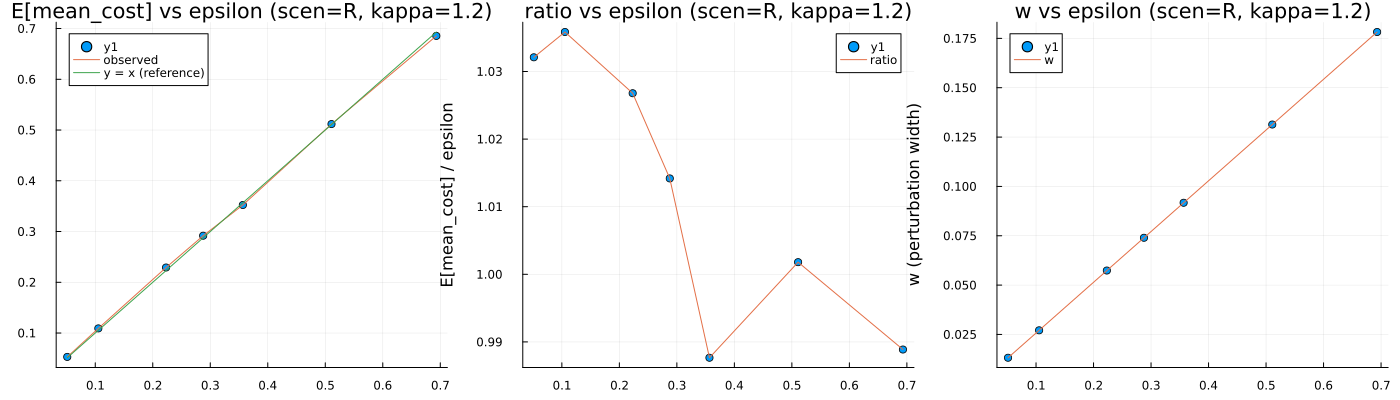

"/Users/xyliu/Desktop/ISE 616 final/ISE-616-final/epsilon_vs_cost(scen=R, kappa=1.2).png"

In [26]:
########################################################
# Plot epsilon vs E[mean_cost] and ratio diagnostics
########################################################
# import Pkg; Pkg.add("Plots")
using Plots

"""
    plot_epsilon_vs_cost(res; title_suffix="")

Given `res::Vector{NamedTuple}` with fields:
  - epsilon
  - mean_cost
  - ratio
  - w
make three plots:
  (1) mean_cost vs epsilon with y=x reference line
  (2) ratio vs epsilon
  (3) w vs epsilon
"""
function plot_epsilon_vs_cost(res; title_suffix::String = "")
    # Extract vectors
    eps   = [r.epsilon for r in res]
    cost  = [r.mean_cost for r in res]
    ratio = [r.ratio for r in res]
    w     = [r.w for r in res]

    # Sort by epsilon (in case input order is not monotone)
    ord = sortperm(eps)
    eps_s   = eps[ord]
    cost_s  = cost[ord]
    ratio_s = ratio[ord]
    w_s     = w[ord]

    # ---- Plot 1: mean_cost vs epsilon ----
    p1 = plot(
        eps_s, cost_s,
        seriestype = :scatter,
        xlabel = "epsilon",
        ylabel = "E[mean_cost]",
        title  = "E[mean_cost] vs epsilon $(title_suffix)",
        legend = :topleft,
    )
    plot!(p1, eps_s, cost_s, seriestype=:line, label="observed")
    plot!(p1, eps_s, eps_s,  seriestype=:line, label="y = x (reference)")

    # ---- Plot 2: ratio vs epsilon ----
    p2 = plot(
        eps_s, ratio_s,
        seriestype = :scatter,
        xlabel = "epsilon",
        ylabel = "E[mean_cost] / epsilon",
        title  = "ratio vs epsilon $(title_suffix)",
        legend = :topright,
    )
    plot!(p2, eps_s, ratio_s, seriestype=:line, label="ratio")

    # ---- Plot 3: w vs epsilon ----
    p3 = plot(
        eps_s, w_s,
        seriestype = :scatter,
        xlabel = "epsilon",
        ylabel = "w (perturbation width)",
        title  = "w vs epsilon $(title_suffix)",
        legend = :topleft,
    )
    plot!(p3, eps_s, w_s, seriestype=:line, label="w")

    # Layout as a 1x3 panel
    plt = plot(p1, p2, p3, layout=(1,3), size=(1400, 400))
    display(plt)
    return plt
end

kappa = 1.2
scen = :R
res = sweep_epsilon_vs_mean_cost(
    scen = scen,
    thetas = [0.5, 0.6, 0.7, 0.75, 0.8, 0.9, 0.95],
    kappa = 1.2,
    R = 30,
    seed = 2025,
    N = 3000,
)
plt = plot_epsilon_vs_cost(res; title_suffix="(scen=$(scen), kappa=$(kappa))")
savefig(plt, "epsilon_vs_cost(scen=$(scen), kappa=$(kappa)).png")



## Real-World Data 

In [18]:
using CSV
using DataFrames
using Statistics

"""
    load_churn_dataset(path; standardize=true)

Load the Bank Customer Churn dataset and convert it to:
- X :: Matrix{Float64}         (continuous features)
- Z :: Matrix{Int}             (integer-coded categorical features, excluding group)
- g :: Vector{Int}             (group index derived from country)
- y :: Vector{Int}             (labels in {-1,+1})
- meta :: NamedTuple           (column info + level mappings + standardization stats)

Conventions:
- group g comes from `country` (France/Germany/Spain), mapped to 1..num_g.
- categorical Z includes: gender, products_number, credit_card, active_member.
- continuous X includes: credit_score, age, tenure, balance, estimated_salary.
"""
function load_churn_dataset(path::AbstractString; standardize::Bool = true)
    df = CSV.read(path, DataFrame)

    # -------------------------
    # 1) Define columns
    # -------------------------
    group_col = :country
    y_col     = :churn

    x_cols = [:credit_score, :age, :tenure, :balance, :estimated_salary]
    z_cols = [:gender, :products_number, :credit_card, :active_member]

    N = nrow(df)

    # -------------------------
    # 2) Build group g from country (SOURCE group concept used elsewhere)
    # -------------------------
    # Fix an explicit order so experiments are reproducible.
    group_levels = ["France", "Germany", "Spain"]
    group_map = Dict(level => i for (i, level) in enumerate(group_levels))

    g = Vector{Int}(undef, N)
    for i in 1:N
        c = string(df[i, group_col])
        @assert haskey(group_map, c) "Unknown country level: $c"
        g[i] = group_map[c]
    end

    # -------------------------
    # 3) Build y in {-1,+1}
    # -------------------------
    y = Vector{Int}(undef, N)
    for i in 1:N
        y[i] = (df[i, y_col] == 1) ? 1 : -1
    end

    # -------------------------
    # 4) Continuous matrix X
    # -------------------------
    X = Matrix{Float64}(undef, N, length(x_cols))
    for (j, col) in enumerate(x_cols)
        X[:, j] = Float64.(df[:, col])
    end

    x_mean = zeros(Float64, size(X, 2))
    x_std  = ones(Float64,  size(X, 2))

    if standardize
        for j in 1:size(X, 2)
            μ = mean(@view X[:, j])
            σ = std(@view X[:, j])
            σ = (σ <= 1e-12) ? 1.0 : σ
            X[:, j] .= (X[:, j] .- μ) ./ σ
            x_mean[j] = μ
            x_std[j]  = σ
        end
    end

    # -------------------------
    # 5) Categorical matrix Z (integer-coded 1..k per column)
    # -------------------------
    Z = Matrix{Int}(undef, N, length(z_cols))
    z_levels = Vector{Vector{String}}(undef, length(z_cols))
    z_maps   = Vector{Dict{String,Int}}(undef, length(z_cols))

    for (ℓ, col) in enumerate(z_cols)
        # Collect levels in a stable order (sorted string)
        lvls = sort!(unique(string.(df[:, col])))
        z_levels[ℓ] = lvls
        mp = Dict(lvl => i for (i, lvl) in enumerate(lvls))
        z_maps[ℓ] = mp

        for i in 1:N
            s = string(df[i, col]) 
            Z[i, ℓ] = mp[s]
        end
    end

    meta = (
        x_cols = x_cols,
        z_cols = z_cols,
        group_col = group_col,
        y_col = y_col,
        group_levels = group_levels,
        group_map = group_map,
        z_levels = z_levels,
        z_maps = z_maps,
        standardize = standardize,
        x_mean = x_mean,
        x_std  = x_std,
    )

    return X, Z, g, y, meta
end


load_churn_dataset

In [19]:
using Statistics  
"""
    summarize_experiment(res_vec)

Given the vector of per-split results returned by `run_experiment`,
compute simple means across splits.

Each element of `res_vec` is expected to have fields:
    (split, auc_avg, auc_min, ace_avg, ace_max)

Returns a NamedTuple:
    (auc_avg_mean, auc_min_mean, ace_avg_mean, ace_max_mean)
"""
function summarize_experiment(res_vec::Vector{<:NamedTuple})
    auc_avg_mean = mean(r.auc_avg for r in res_vec)
    auc_min_mean = mean(r.auc_min for r in res_vec)
    ace_avg_mean = mean(r.ace_avg for r in res_vec)
    ace_max_mean = mean(r.ace_max for r in res_vec)
    return (
        auc_avg_mean = auc_avg_mean,
        auc_min_mean = auc_min_mean,
        ace_avg_mean = ace_avg_mean,
        ace_max_mean = ace_max_mean,
    )
end


summarize_experiment

In [ ]:
# using Random
# using Ipopt
# using CSV, DataFrames   # harmless if already loaded

# """
#     run_churn_scenarios(
#         path;
#         severities = [:mild, :strong],
#         thetas = [0.5, 0.75, 0.9],
#         train_ratio = 0.7,
#         n_splits = 2,
#         n_pert_per_split = 100,
#         lambda_l2 = 0.01,
#         seed = 2025,
#         max_samples_per_scenario = nothing,
#         optimizer = optimizer_with_attributes(Ipopt.Optimizer, "print_level" => 0),
#     )

# Run subgroup-DRO vs standard logistic regression on the Bank Customer
# Churn dataset, under a grid of (severity, θ) settings.

# For each (severity, θ):
#   1. Optionally subsample at most `max_samples_per_scenario` points.
#   2. Build DROParams and PerturbParams via `build_churn_params`.
#   3. Run `run_experiment` with method = :dro.
#   4. Run `run_experiment` with method = :logistic.
#   5. Summarize each via `summarize_experiment`.

# Inputs
# ------
# - path                    : path to "Bank Customer Churn Prediction.csv".
# - severities              : e.g. [:mild, :strong].
# - thetas                  : robustness levels θ in (0,1).
# - train_ratio             : fraction of samples used for training in each split.
# - n_splits                : number of random train/test splits.
# - n_pert_per_split        : number of perturbed test sets per split.
# - lambda_l2               : L2-regularization coefficient for logistic baseline.
# - seed                    : base random seed.
# - max_samples_per_scenario: if not `nothing`, limit each (severity, θ) scenario
#                             to this many samples by random subsampling.
# - optimizer               : JuMP optimizer for both models.

# Returns
# -------
# - results :: Vector{NamedTuple}

# Each element has fields:
#     (severity, theta, method,
#      auc_avg_mean, auc_min_mean, ace_avg_mean, ace_max_mean)
# """
# function run_churn_scenarios(
#     path::AbstractString;
#     severities = [:mild, :strong],
#     thetas = [0.5, 0.75, 0.9],
#     train_ratio::Float64 = 0.7,
#     n_splits::Int = 2,
#     n_pert_per_split::Int = 100,
#     lambda_l2::Float64 = 0.01,
#     seed::Int = 2025,
#     max_samples_per_scenario::Union{Nothing,Int} = nothing,
#     optimizer = optimizer_with_attributes(Ipopt.Optimizer, "print_level" => 0),
# )
#     # Load the full dataset once
#     X_full, Z_full, g_full, y_full, meta = load_churn_dataset(path)
#     N_full = size(X_full, 1)

#     # Logistic baseline hyperparameter
#     logit_params = LogitParams(lambda_l2)

#     # One RNG is enough here; runs are unpaired but share the same distribution
#     rng = Random.MersenneTwister(seed)

#     results = NamedTuple[]

#     # Loop over (severity, theta)
#     for sev in severities
#         for θ in thetas
#             # Decide which subset of samples to use for this (sev, θ) scenario
#             if max_samples_per_scenario === nothing || max_samples_per_scenario >= N_full
#                 # Use all samples
#                 X = X_full
#                 Z = Z_full
#                 g = g_full
#                 y = y_full
#             else
#                 # Randomly choose a subset of size max_samples_per_scenario
#                 idx_sub = randperm(rng, N_full)[1:max_samples_per_scenario]
#                 X = X_full[idx_sub, :]
#                 Z = Z_full[idx_sub, :]
#                 g = g_full[idx_sub]
#                 y = y_full[idx_sub]
#             end

#             n_x  = size(X, 2)
#             m    = size(Z, 2)
#             num_g = maximum(g)

#             # Build DRO and perturbation parameters for this scenario
#             dro_params, pert_params =
#                 build_churn_params(sev, θ; n_x = n_x, m = m, num_g = num_g)

#             # Run DRO model on this (possibly subsampled) dataset
#             res_dro = run_experiment(
#                 X, Z, g, y;
#                 train_ratio       = train_ratio,
#                 method            = :dro,
#                 dro_params        = dro_params,
#                 pert_params       = pert_params,
#                 n_splits          = n_splits,
#                 n_pert_per_split  = n_pert_per_split,
#                 rng               = rng,
#                 optimizer         = optimizer,
#             )
#             sum_dro = summarize_experiment(res_dro)

#             push!(results, (
#                 severity      = sev,
#                 theta         = θ,
#                 method        = :dro,
#                 auc_avg_mean  = sum_dro.auc_avg_mean,
#                 auc_min_mean  = sum_dro.auc_min_mean,
#                 ace_avg_mean  = sum_dro.ace_avg_mean,
#                 ace_max_mean  = sum_dro.ace_max_mean,
#             ))

#             # Run logistic baseline on the same (possibly subsampled) dataset
#             res_log = run_experiment(
#                 X, Z, g, y;
#                 train_ratio       = train_ratio,
#                 method            = :logistic,
#                 dro_params        = dro_params,  
#                 logit_params      = logit_params,
#                 pert_params       = pert_params,
#                 n_splits          = n_splits,
#                 n_pert_per_split  = n_pert_per_split,
#                 rng               = rng,
#                 optimizer         = optimizer,
#             )
#             sum_log = summarize_experiment(res_log)

#             push!(results, (
#                 severity      = sev,
#                 theta         = θ,
#                 method        = :logistic,
#                 auc_avg_mean  = sum_log.auc_avg_mean,
#                 auc_min_mean  = sum_log.auc_min_mean,
#                 ace_avg_mean  = sum_log.ace_avg_mean,
#                 ace_max_mean  = sum_log.ace_max_mean,
#             ))
#         end
#     end

#     return results
# end


run_churn_scenarios

In [ ]:
# path = "Bank Customer Churn Prediction.csv"

# results_churn = run_churn_scenarios(
#     path;
#     severities = [:mild, :strong],
#     thetas = [0.5, 0.75, 0.9],
#     train_ratio = 0.7,
#     n_splits = 8,
#     n_pert_per_split = 100,
#     lambda_l2 = 0.01,
#     seed = 2025,
#     max_samples_per_scenario = 2000,   # <-- this is the cap
# )

# println.(results_churn)



MethodError: MethodError: no method matching String(::Int64)
The type `String` exists, but no method is defined for this combination of argument types when trying to construct it.

Closest candidates are:
  String(!Matched::PosLenString)
   @ WeakRefStrings ~/.julia/packages/WeakRefStrings/31nkb/src/poslenstrings.jl:50
  String(!Matched::Vector{UInt8})
   @ Base strings/string.jl:65
  String(!Matched::Symbol)
   @ Base strings/string.jl:118
  ...


In [ ]:
# using DataFrames

# """
#     summarize_differences(results_churn)

# Convert the vector of NamedTuples returned by `run_churn_scenarios`
# into a DataFrame with one row per (severity, theta), and columns:

# - auc_dro, auc_log, delta_auc = auc_dro - auc_log
# - ace_dro, ace_log, delta_ace = ace_dro - ace_log
# """
# function summarize_differences(results_churn)
#     df = DataFrame(results_churn)

#     # pivot: two rows per config -> one row per (severity, theta)
#     configs = unique(df[:, [:severity, :theta]])
#     out = DataFrame(
#         severity = String[],
#         theta    = Float64[],
#         auc_dro  = Float64[],
#         auc_log  = Float64[],
#         delta_auc = Float64[],
#         ace_dro  = Float64[],
#         ace_log  = Float64[],
#         delta_ace = Float64[],
#     )

#     for row in eachrow(configs)
#         sev = row.severity
#         θ   = row.theta

#         sub = df[(df.severity .== sev) .& (df.theta .== θ), :]

#         dro_row = sub[sub.method .== :dro, :]
#         log_row = sub[sub.method .== :logistic, :]

#         auc_dro = dro_row.auc_avg_mean[1]
#         auc_log = log_row.auc_avg_mean[1]
#         ace_dro = dro_row.ace_avg_mean[1]
#         ace_log = log_row.ace_avg_mean[1]

#         push!(out, (
#             string(sev),
#             θ,
#             auc_dro,
#             auc_log,
#             auc_dro - auc_log,
#             ace_dro,
#             ace_log,
#             ace_dro - ace_log,
#         ))
#     end

#     return out
# end

# df_diff = summarize_differences(results_churn)
# println(df_diff)


UndefVarError: UndefVarError: `results_churn` not defined in `Main`
Suggestion: add an appropriate import or assignment. This global was declared but not assigned.

In [20]:
############################################################
# Churn: scenario-based DRO + perturb parameters (U / V / R)
############################################################

"""
    build_churn_scenario_params(scenario, theta;
                                n_x, m, num_g, kappa = 1.0)

Build (dro_params, pert_params) for the Bank Churn dataset
under one of three subgroup metric scenarios:

- :U (Uniform):   A_g = B_g = C_g = 1         for all groups.
- :V (Vulnerable): (A,B,C) = (0.5,0.5,0.5) for group 1,
                   (1,1,1)               for group 2,
                   (2,2,2)               for group 3.
- :R (Reversed):   same pattern as :V but swap group 1 and 3.

Here we keep the data-generating side (γ_x, δ) simple:

- γ_x[j] = 1     for all continuous features (already standardized).
- δ[ℓ]  = 1     for all categorical features.
- ε = -log(theta).

The perturbation object only carries (mode, w ) , where w is derived from (epsilon, kappa).
(A_g · γ_x, B_g · δ, C_g) controls how large the actual shifts are
inside `perturb_testset`.
"""
function build_churn_scenario_params(
    scenario::Symbol,
    theta::Float64;
    n_x::Int,
    m::Int,
    num_g::Int,
    kappa::Float64 = 1.0,
)
    @assert num_g == 3 "This helper assumes 3 groups (France / Germany / Spain)."

    # Base feature scales
    gamma_x = ones(Float64, n_x)
    delta   = ones(Float64, m)

    # Scenario-specific A_g, B_g, C_g
    A_group = zeros(Float64, num_g)
    B_group = zeros(Float64, num_g)
    C_group = zeros(Float64, num_g)

    if scenario == :U
        # All groups equally easy to move
        A_group .= 1.0
        B_group .= 1.0
        C_group .= 1.0

    elseif scenario == :V
        # Group 1 most vulnerable, group 3 most robust
        A_group .= [0.5, 1.0, 2.0]
        B_group .= [0.5, 1.0, 2.0]
        C_group .= [0.5, 1.0, 2.0]

    elseif scenario == :R
        # Reverse: group 3 most vulnerable, group 1 most robust
        A_group .= [2.0, 1.0, 0.5]
        B_group .= [2.0, 1.0, 0.5]
        C_group .= [2.0, 1.0, 0.5]

    else
        error("Unknown scenario = $scenario. Use :U, :V or :R.")
    end

    # DRO radius
    epsilon = -log(theta)

    dro_params = DROParams(
        delta,
        A_group,
        B_group,
        C_group,
        gamma_x,
        epsilon,
    )

    # Perturbation knob w: global noise budget
    pert_params = dro_to_perturb_params(dro_params; kappa = kappa, mode = scenario)

    return dro_params, pert_params
end


build_churn_scenario_params

In [21]:
############################################################
# Churn experiment driver (U / V / R, 1000-sample subset)
############################################################

using Random
using Statistics
using Ipopt

"""
    run_churn_scenarios_uvr(
        path;
        scenarios = [:U, :V, :R],
        thetas = [0.5, 0.75, 0.9],
        train_ratio = 0.7,
        n_splits = 5,
        n_pert_per_split = 100,
        lambda_l2 = 1e-2,
        max_samples = 1000,
        kappa = 1.0,
        seed = 2025,
        optimizer = optimizer_with_attributes(Ipopt.Optimizer, "print_level" => 0),
    )

Apply the same U / V / R subgroup-metric pipeline to the
Bank Customer Churn dataset, using only a random subset of
at most `max_samples` points for speed.

For each scenario ∈ {U,V,R} and θ ∈ {0.5,0.75,0.9}:

1. Build (dro_params, pert_params) via `build_churn_scenario_params`.
2. Run `run_experiment` with method = :dro.
3. Run `run_experiment` with method = :logistic (same perturbation law).
4. Aggregate per-split summaries into means over splits.

Returns a vector of NamedTuples with fields:
    (scenario, theta, method, auc_avg_mean, auc_min_mean,
     ace_avg_mean, ace_max_mean)
"""
function run_churn_scenarios_uvr(
    path::AbstractString;
    scenarios = [:U, :V, :R],
    thetas = [0.5, 0.75, 0.9],
    train_ratio::Float64 = 0.7,
    n_splits::Int = 5,
    n_pert_per_split::Int = 100,
    lambda_l2::Float64 = 1e-2,
    max_samples::Int = 1000,
    kappa::Float64 = 1.0,
    seed::Int = 2025,
    optimizer = optimizer_with_attributes(Ipopt.Optimizer, "print_level" => 0),
)
    rng = MersenneTwister(seed)

    # 1) Load and subsample dataset
    X_full, Z_full, g_full, y_full, meta = load_churn_dataset(path; standardize = true)
    N_total = size(X_full, 1)
    N_use   = min(max_samples, N_total)

    idx_sub = randperm(rng, N_total)[1:N_use]
    X = X_full[idx_sub, :]
    Z = Z_full[idx_sub, :]
    g = g_full[idx_sub]
    y = y_full[idx_sub]

    n_x  = size(X, 2)
    m    = size(Z, 2)
    num_g = maximum(g)

    logit_params = LogitParams(lambda_l2)

    results = NamedTuple[]

    for scen in scenarios
        #println(scen)
        for θ in thetas
            println("Scenario = ", scen, ", theta = ", θ, ", kappa = ", kappa)
            # 2) Build DRO + perturbation parameters for this scenario
            dro_params, pert_params = build_churn_scenario_params(
                scen, θ;
                n_x = n_x,
                m = m,
                num_g = num_g,
                kappa = kappa,
            )

            # 3) DRO model
            res_dro = run_experiment(
                X, Z, g, y;
                train_ratio = train_ratio,
                method = :dro,
                dro_params = dro_params,
                logit_params = logit_params,
                pert_params = pert_params,
                n_splits = n_splits,
                n_pert_per_split = n_pert_per_split,
                rng = rng,
                optimizer = optimizer,
            )

            # 4) Logistic baseline
            res_logit = run_experiment(
                X, Z, g, y;
                train_ratio = train_ratio,
                method = :logistic,
                dro_params = dro_params,
                logit_params = logit_params,
                pert_params = pert_params,
                n_splits = n_splits,
                n_pert_per_split = n_pert_per_split,
                rng = rng,
                optimizer = optimizer,
            )

            # 5) Average the per-split summaries
            for (method, res) in zip((:dro, :logistic), (res_dro, res_logit))
                auc_avg_mean = mean(r.auc_avg for r in res)
                auc_min_mean = mean(r.auc_min for r in res)
                ace_avg_mean = mean(r.ace_avg for r in res)
                ace_max_mean = mean(r.ace_max for r in res)

                push!(results, (
                    scenario     = scen,
                    theta        = θ,
                    method       = method,
                    auc_avg_mean = auc_avg_mean,
                    auc_min_mean = auc_min_mean,
                    ace_avg_mean = ace_avg_mean,
                    ace_max_mean = ace_max_mean,
                ))
            end
        end
    end

    return results
end


run_churn_scenarios_uvr

In [ ]:
path = "Bank Customer Churn Prediction.csv"

results_churn_uvr = run_churn_scenarios_uvr(
    path;
    scenarios = [:U, :V, :R],
    thetas = [0.5, 0.75, 0.9],
    train_ratio = 0.7,
    n_splits = 10,
    n_pert_per_split = 40,
    lambda_l2 = 1e-2,
    max_samples = 1000,
    kappa = 1.0,
    seed = 2025,
)



Scenario = U, theta = 0.5, kappa = 1.0
[run_experiment] Split 1/10, perturb 1/40
[run_experiment] Split 1/10, perturb 10/40
[run_experiment] Split 1/10, perturb 20/40
[run_experiment] Split 1/10, perturb 30/40
[run_experiment] Split 1/10, perturb 40/40
[run_experiment] Split 2/10, perturb 1/40
[run_experiment] Split 2/10, perturb 10/40
[run_experiment] Split 2/10, perturb 20/40
[run_experiment] Split 2/10, perturb 30/40
[run_experiment] Split 2/10, perturb 40/40
[run_experiment] Split 3/10, perturb 1/40
[run_experiment] Split 3/10, perturb 10/40
[run_experiment] Split 3/10, perturb 20/40
[run_experiment] Split 3/10, perturb 30/40
[run_experiment] Split 3/10, perturb 40/40
[run_experiment] Split 4/10, perturb 1/40
[run_experiment] Split 4/10, perturb 10/40
[run_experiment] Split 4/10, perturb 20/40
[run_experiment] Split 4/10, perturb 30/40
[run_experiment] Split 4/10, perturb 40/40
[run_experiment] Split 5/10, perturb 1/40
[run_experiment] Split 5/10, perturb 10/40
[run_experiment] Spl

In [ ]:
# using Random
# using Ipopt
# using CSV, DataFrames   # harmless if already loaded

# """
#     run_churn_scenarios(
#         path;
#         severities = [:mild, :strong],
#         thetas = [0.5, 0.75, 0.9],
#         train_ratio = 0.7,
#         n_splits = 2,
#         n_pert_per_split = 100,
#         lambda_l2 = 0.01,
#         seed = 2025,
#         max_samples_per_scenario = nothing,
#         optimizer = optimizer_with_attributes(Ipopt.Optimizer, "print_level" => 0),
#     )

# Run subgroup-DRO vs standard logistic regression on the Bank Customer
# Churn dataset, under a grid of (severity, θ) settings.

# For each (severity, θ):
#   1. Optionally subsample at most `max_samples_per_scenario` points.
#   2. Build DROParams and PerturbParams via `build_churn_params`.
#   3. Run `run_experiment` with method = :dro.
#   4. Run `run_experiment` with method = :logistic.
#   5. Summarize each via `summarize_experiment`.

# Inputs
# ------
# - path                    : path to "Bank Customer Churn Prediction.csv".
# - severities              : e.g. [:mild, :strong].
# - thetas                  : robustness levels θ in (0,1).
# - train_ratio             : fraction of samples used for training in each split.
# - n_splits                : number of random train/test splits.
# - n_pert_per_split        : number of perturbed test sets per split.
# - lambda_l2               : L2-regularization coefficient for logistic baseline.
# - seed                    : base random seed.
# - max_samples_per_scenario: if not `nothing`, limit each (severity, θ) scenario
#                             to this many samples by random subsampling.
# - optimizer               : JuMP optimizer for both models.

# Returns
# -------
# - results :: Vector{NamedTuple}

# Each element has fields:
#     (severity, theta, method,
#      auc_avg_mean, auc_min_mean, ace_avg_mean, ace_max_mean)
# """
# function run_churn_scenarios(
#     path::AbstractString;
#     severities = [:mild, :strong],
#     thetas = [0.5, 0.75, 0.9],
#     train_ratio::Float64 = 0.7,
#     n_splits::Int = 2,
#     n_pert_per_split::Int = 100,
#     lambda_l2::Float64 = 0.01,
#     seed::Int = 2025,
#     max_samples_per_scenario::Union{Nothing,Int} = nothing,
#     optimizer = optimizer_with_attributes(Ipopt.Optimizer, "print_level" => 0),
# )
#     # Load the full dataset once
#     X_full, Z_full, g_full, y_full, meta = load_churn_dataset(path)
#     N_full = size(X_full, 1)

#     # Logistic baseline hyperparameter
#     logit_params = LogitParams(lambda_l2)

#     # One RNG is enough here; runs are unpaired but share the same distribution
#     rng = Random.MersenneTwister(seed)

#     results = NamedTuple[]

#     # Loop over (severity, theta)
#     for sev in severities
#         for θ in thetas
#             # Decide which subset of samples to use for this (sev, θ) scenario
#             if max_samples_per_scenario === nothing || max_samples_per_scenario >= N_full
#                 # Use all samples
#                 X = X_full
#                 Z = Z_full
#                 g = g_full
#                 y = y_full
#             else
#                 # Randomly choose a subset of size max_samples_per_scenario
#                 idx_sub = randperm(rng, N_full)[1:max_samples_per_scenario]
#                 X = X_full[idx_sub, :]
#                 Z = Z_full[idx_sub, :]
#                 g = g_full[idx_sub]
#                 y = y_full[idx_sub]
#             end

#             n_x  = size(X, 2)
#             m    = size(Z, 2)
#             num_g = maximum(g)

#             # Build DRO and perturbation parameters for this scenario
#             dro_params, pert_params =
#                 build_churn_params(sev, θ; n_x = n_x, m = m, num_g = num_g)

#             # Run DRO model on this (possibly subsampled) dataset
#             res_dro = run_experiment(
#                 X, Z, g, y;
#                 train_ratio       = train_ratio,
#                 method            = :dro,
#                 dro_params        = dro_params,
#                 pert_params       = pert_params,
#                 n_splits          = n_splits,
#                 n_pert_per_split  = n_pert_per_split,
#                 rng               = rng,
#                 optimizer         = optimizer,
#             )
#             sum_dro = summarize_experiment(res_dro)

#             push!(results, (
#                 severity      = sev,
#                 theta         = θ,
#                 method        = :dro,
#                 auc_avg_mean  = sum_dro.auc_avg_mean,
#                 auc_min_mean  = sum_dro.auc_min_mean,
#                 ace_avg_mean  = sum_dro.ace_avg_mean,
#                 ace_max_mean  = sum_dro.ace_max_mean,
#             ))

#             # Run logistic baseline on the same (possibly subsampled) dataset
#             res_log = run_experiment(
#                 X, Z, g, y;
#                 train_ratio       = train_ratio,
#                 method            = :logistic,
#                 dro_params        = dro_params,  
#                 logit_params      = logit_params,
#                 pert_params       = pert_params,
#                 n_splits          = n_splits,
#                 n_pert_per_split  = n_pert_per_split,
#                 rng               = rng,
#                 optimizer         = optimizer,
#             )
#             sum_log = summarize_experiment(res_log)

#             push!(results, (
#                 severity      = sev,
#                 theta         = θ,
#                 method        = :logistic,
#                 auc_avg_mean  = sum_log.auc_avg_mean,
#                 auc_min_mean  = sum_log.auc_min_mean,
#                 ace_avg_mean  = sum_log.ace_avg_mean,
#                 ace_max_mean  = sum_log.ace_max_mean,
#             ))
#         end
#     end

#     return results
# end
